Student Name: Maria Nikolova 
Matricola: 5201031

**Note:** If viewing this notebook in Jupyter Notebook, it is recommended to use the 'Hide input all' extension from Nbextensions. This extension allows you to hide less relevant or less interesting parts, enhancing the readability of the notebook.

I will be utilizing a CSV file generated after web scraping the dataset. This approach is chosen for its efficiency, considering the significant time required for web scraping and the meticulous encoding of missing values through a micro-level strategy.

There will be detailed description of each action taken in the Modelling Part so as to assess the performance of each Model and its parameters.

Variables and vectorizers will be restated in certain instances. This is deemed necessary to accommodate diverse data transformations and harness the flexibility for various data processing techniques.

**Specific Note for Random Forest**: If you rerun the code (after the scrapping), the final plot (in the comperison section) might experinece some issues with the results of the Random Forest model. The code is fine, it just requires a rerun. 


***News Page used:*** https://www.vox.com

## Content

- **Import libraries and Definition of needed functions for NLP**

- **Web Scraping Articles**
    - Data to be webscraped:
        - Content: the text of the article
        - Category: the category of the article
        - Title: the title of the article
        - Author: the author of the article
        - Link: check the artcile in case of need

- **Data Cleaning**
    - Visualize data
    - Encoding of missing values
    - Check if some of the articles belong to more than one category (hint: yes there are articles that belong to more than one category)

### Single-Label Classification

- **Multinomial Bayes**
    1. Running the Multinomial Bayes model (with different numbers of seeds and checking 4 matrices (Jaccard index, Accuracy, F1 weighted, and F1 non-weighted))
    2. Running the Multinomial Bayes with a single seed and checking the confusion matrix to see possible issues coming from unbalanced data
    3. Balancing the Data and comparing the results
    4. Tuning the Alpha (Additive Laplace/Lidstone Smoothing) Parameter
    5. Interpretation of the Results from Multinomial Naive Bayes

- **Complement Naive Bayes**
    1. Run the Complement Bayes on the unbalanced data 
    2. Interpretation of the Results of Complement Naive Bayes
    3. Plot a Comparison of the Results: Complement Naive Bayes vs. Multinomial Naive Bayes

- **Decision Tree**
    1. Running the model by using Bag-of-words representation using CountVectorizer for the articles' content
    2. Running the model by using TF-IDF (Term Frequency-Inverse Document Frequency) (High number of features in the dataset)
    3. Plotting a Comparison between 1) and 2) and comparing the gini and entropy impurity matrices
    4. Employing TF-IDF and Dimensionality Reduction by hashing
    5. Interpretation of the Results
    6. Plot matrices for each approach: comparison results

- **Random Forest**
    1. Applying the Random Forest by using CountVectorizer()
    2. Applying the Random Forest by using TfidfVectorizer (High Dimensional)
    3. Hyperparameter Tuning: n_estimators
    4. Interpretation of the Random Forest model results for Classification

- **Support Vector Machine**
    1. Support Vector Machine by applying the linear kernel (using TfidfVectorizer()) by using both Author and Content as explanatory variables
    2. SVM, applied by using the Radial Basis Function (RBF) kernel and cross-validation for checking the best parameters
    3. SVM applied by using the Polynomial kernel
    4. Checking if the model performs better when only the Author or the Content Variable is used
    5. Interpretation of the SVM results

- **Logistic Regression**
    1. Run the Logistic Regression with Content and Author as explanatory variables
    2. Hyperparameter tuning by using the Grid Search so as to find the optimal parameters for tuning
    3. Running the tuned Logistic Regression with a single explanatory Variable
    4. Interpretation of Results

### Comparison between the Models
### The Champion (The Best Classifier)

   

## Import libraries and Defnition of needed functions ##

In [1]:
#Libraries for data structures, maths, stats
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
from scipy.stats import chi2, chi2_contingency
import nltk
import numpy as np
from scipy.sparse import hstack


#NeutralLabguageP, Vectorize, Split, Encode 
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder

#Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import t
from scipy import stats
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression



#Valuation and Perfomance and Param tunning
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer
from sklearn.metrics import confusion_matrix
from memory_profiler import profile
from sklearn.metrics import jaccard_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#Heatmap and Plots
import seaborn as sns
import matplotlib.pyplot as plt

#Sample Balance
from imblearn.over_sampling import RandomOverSampler


In [2]:
#NLP functions
#Check for html tags
def check_html_tags(text_column):
    html_tags_check = text_column.str.contains('<.*?>', regex=True).any()    
    if html_tags_check:
        print('HTML tags present')
    else:
        print('All HTML tags removed.')
        
#check_html_tags(unique_titles_df['Content'])


                
#Turn everything into lowercase
def convert_to_lowercase(text):
    return text.lower()
#unique_titles_df['Content'] = unique_titles_df['Content'].apply(convert_to_lowercase)



#Remove non-alphanumeric characters
def remove_special_chars(text):
    return ''.join(char for char in text if char.isalnum() or char.isspace())
#unique_titles_df['Content'] = unique_titles_df['Content'].apply(remove_special_chars)



#tokenize the text by words
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens
#unique_titles_df['Tokens'] = unique_titles_df['Content'].apply(tokenize_text)


#remove stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]
#unique_titles_df['Tokens'] = unique_titles_df['Tokens'].apply(remove_stopwords)


#lemmatize the tokens
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token)for token in tokens]
    return lemmatized_tokens
#unique_titles_df['Lemmatized_Tokens'] = unique_titles_df['Tokens'].apply(lemmatize_tokens)



#lemmatized tokens into a single string
def join_lemmatized_tokens(tokens):
    processed_text = ' '.join(tokens)
    return processed_text

#unique_titles_df['ProcessedText'] = unique_titles_df['Lemmatized_Tokens'].apply(join_lemmatized_tokens)


In [ ]:
# Create Function to extract 'content' from HTML code of the Vox page by using BS library
def extract_content(html_code):
    soup = BeautifulSoup(html_code, 'html.parser')

    # Exclude the footer common to all articles 
    
    footer_div = soup.find('div', class_='c-article-footer c-article-footer-cta')
    if footer_div:
        for element in footer_div.find_all(['p']):
            element.decompose() #to remove the tag and the content form the connet that will be web scapped 
      

    paragraphs = soup.find('div', class_='c-entry-content').find_all('p')
    content = [paragraph.get_text() for paragraph in paragraphs]
    return content

## Web Scrapping Articles ##

**I chose the Vox website for web scraping.**

These are the categories (all the categories in the website) with which I will work for in this project and will be the target variable for my news classifier:

1) **politics**
2) **culture**
3) **policy**
4) **science**
5) **technology**
6) **climate**
7) **health**
8) **money**
9) **life**

From each category, I web scraped 320 articles. The scope is creating a robust dataset.<br>
The expected number of categories is: **2880**<br>
I will work with a **CSV file** that will be created after the data is web scraped because the execution of the code takes around an hour and a half in my case).

Additionally, in the next part, considering the very low number of missing values I decided to take a **micro approach towards encoding**. This approach, however, requires additional manipulation in case the web scraping is re-executed.


In [ ]:
#URLs (each URL represents a category)
#Key:the category
#Value: the URL
urls = {
    'politics': 'https://www.vox.com/politics/archives',
    'culture': 'https://www.vox.com/culture/archives',
    'policy': 'https://www.vox.com/policy/archives',
    'science': 'https://www.vox.com/science/archives',
    'technology': 'https://www.vox.com/technology/archives',
    'climate': 'https://www.vox.com/climate/archives',
    'health': 'https://www.vox.com/health/archives',
    'money': 'https://www.vox.com/money/archives',
    'life': 'https://www.vox.com/life/archives',
}

#Create a dataframe to keep the data 

df = pd.DataFrame(columns=['Title', 'Author', 'Category', 'Link', 'Content'])

In [ ]:
# Setting the maximum number of pages to scrape (every page 40 artciles (valid for all categories))
# 9 Categories 
#320 articles per category 
#2880 artcles expected 

max_pages = 8

#Iterate though the keys and the values form the dictionary
for category, url in urls.items():
    #Using the numb variable so that I can iterate though the pages of the Archive
    #Example:Page 1 url: https://www.vox.com/life/archives/1 (equvalent: 'https://www.vox.com/life/archives'); 
    #Page 2 url: https://www.vox.com/life/archives/2
    numb = 1
    page_count = 0  # Page count 

    
    while page_count < max_pages:
        next_page = f"{url}/{numb}"
        numb += 1
        
        #mimic the behavior of a real user just in case (prevent being blocked)
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

        #Send a GET request to the URL 
        response = requests.get(next_page, headers=headers)

        #Break the loop un case of unsuccessful response
        if response.status_code != 200:
            break

        #Parse the HTML content of the page and get the soup object
        soup = BeautifulSoup(response.text, 'html.parser')

        #Define article_boxes: find all HTML elements with the class 'c-entry-box--compact'
        article_boxes = soup.select('.c-entry-box--compact')

        for article_box in article_boxes:
            #Get the article title
            article_title = article_box.select_one('.c-entry-box--compact__title').text.strip()

            #Get the article author
            article_vox_author = article_box.select_one('.c-byline__item')

            if article_vox_author:
                #Two types of authors: 
                #1) Individual Author (Example:Umair Irfan )
                #2) Vox Staff
                #In case 1 (Individual there is a hyperlink leading to the page of the author)
                #In case 2 there is no hyperlink 
                #We are using the anchor tag as a way to differentaite between artcles 
                
                author_link = article_vox_author.find('a')
                #Individual Author
                if author_link:
                    article_vox_author = author_link.find('span', class_='c-byline__author-name').text.strip()
                #Vox Staff
                else:
                    article_vox_author = article_vox_author.text.strip()

            #Extract the article link
            article_url = article_box.select_one('.c-entry-box--compact__title a')['href']

            #Sending a GET request to article URL (entering in every page to get the body)
            article_response = requests.get(article_url, headers=headers)

            if article_response.status_code == 200:
                #Parse the HTML content of the article
                article_soup = BeautifulSoup(article_response.text, 'html.parser')

                #Get the article content
                #2 types of articles: 
                #1)Dynamical articles with calss 'c-entry-content c-entry-content__stream'
                #2)Static Articles with class 'c-entry-content'
                if article_soup.find('div', class_='c-entry-content c-entry-content__stream'):
                    content = extract_content(str(article_soup.find('div', class_='c-entry-content c-entry-content__stream')))
                elif article_soup.find('div', class_='c-entry-content'):
                    content = extract_content(str(article_soup.find('div', class_='c-entry-content')))
                else:
                    print("Could not identify the code structure for content.")
                    content = ""

                #Append the data to the DataFrame with the category information
                df = df.append({'Title': article_title, 'Author': article_vox_author, 'Category': category, 'Link': article_url, 'Content': content},
                               ignore_index=True)
                
            print(f"Title: {article_title}")
            print(f"Author: {article_vox_author}")
            print(f"Link: {article_url}")
            print(f"Category: {category}\n")
            print(f"Content: {content}\n")


        page_count += 1  #Increment the page count: stop the loop after the 4th page 
        
        
df.to_csv('News_Classification_project_2.csv', index=False)

In [3]:
df = pd.read_csv('News_Classification_project_2.csv')
df.shape

(2880, 5)

## Data Cleaing ##

In [4]:
#Considering the amount of missung values (low) I apply a more micro approach
rows_with_missing_values = df[df.isnull().any(axis=1)]

# Print the rows with missing values
print("Rows with missing values:")
print(rows_with_missing_values)

Rows with missing values:
                                                  Title Author Category  \
356                        The United States of Florida    NaN  culture   
611   Everything you need to know about the 95th Aca...    NaN  culture   
640                    The Vox guide to open enrollment    NaN   policy   
1655                      The Vox guide to extreme heat    NaN  climate   
2608                                  How to travel now    NaN     life   

                                                   Link  \
356   https://www.vox.com/culture/23864468/florida-m...   
611   https://www.vox.com/culture/23628961/oscars-20...   
640   https://www.vox.com/23914351/health-insurance-...   
1655  https://www.vox.com/climate/23805954/extreme-h...   
2608  https://www.vox.com/travel/23735934/how-to-tra...   

                                                Content  
356   ['Americans like to think Florida is an outlie...  
611   ['The 95th Academy Awards will kick off on Mar

### Encoding (using chi^2 test for association) ###

We see that there are **5 elements missing** which all belong to the same category 'Author'.

Considering the low value of missing values, I checked all five articles with missing author.<br> These articles are all 'pre-articles' of a sequence of articles. Each sequence of articles was focusing on one category (one topic; example: climate, traveling, etc.)
**After taking a look at the articles of the sequences, I noticed that some authors had written more than one article in all the sequences (with one exception).**

Considering the scope of the 'author' variable role, **namely a possible explanatory variable**, I took the
names of the authors that had written more than one article and I ran chi-square tests **to see if there is an
association between the author (with more than one article in the sequence) and the category of the article
with missing author**.


In [5]:
#Title: The Vox guide to extreme heat  Author: NaN    Category: climate 

contingency_table_1 = pd.crosstab(df['Author'] == 'Umair Irfan', df['Category'] == 'climate')

print("Contingency Table:")
print(contingency_table_1)

chi2_1, p,_,_ = chi2_contingency(contingency_table_1)

if p<0.01:
    print(f"\nChi-Square Value: {chi2_1}")
    print(f"P-Value: {p}")
    print('We can reject the null hypothesis. The author is associated with the category')
    df.loc[1655].fillna('Umair Irfan', inplace=True)
    print(f"We encode {df['Author'].loc[1655]}")
    

#We encode 'Umair Irfan'

Contingency Table:
Category  False  True
Author               
False      2464   264
True         96    56

Chi-Square Value: 104.83931258681896
P-Value: 1.324532001264922e-24
We can reject the null hypothesis. The author is associated with the category
We encode Umair Irfan


In [6]:
#Title:Everything you need to know about the 95th Academy AwardsAuthor: NaN    Category: culture 

contingency_table_1 = pd.crosstab(df['Author'] == 'Alissa Wilkinson', df['Category'] == 'culture')

print("Contingency Table:")
print(contingency_table_1)

chi2_1, p,_,_ = chi2_contingency(contingency_table_1)

if p<0.01:
    print(f"\nChi-Square Value: {chi2_1}")
    print(f"P-Value: {p}")
    print('We can reject the null hypothesis. The author is associated with the category')
    df.loc[611].fillna('Alissa Wilkinson', inplace=True)
    print(f"We encode {df['Author'].loc[611]}")


#We encode 'Alissa Wilkinson'


Contingency Table:
Category  False  True
Author               
False      2551   275
True          9    45

Chi-Square Value: 283.23248407643314
P-Value: 1.4831873758495968e-63
We can reject the null hypothesis. The author is associated with the category
We encode Alissa Wilkinson


In [7]:

#Title:The Vox guide to open enrollment  Author: NaN    Category: policy 

contingency_table_1 = pd.crosstab(df['Author'] == 'Dylan Scott', df['Category'] == 'policy')

print("Contingency Table:")
print(contingency_table_1)

chi2_1, p,_,_ = chi2_contingency(contingency_table_1)

if p<0.01:
    print(f"\nChi-Square Value: {chi2_1}")
    print(f"P-Value: {p}")
    print('We can reject the null hypothesis. The author is associated with the category')
    df.loc[640].fillna('Dylan Scott', inplace=True)
    print(f"We encode: {df['Author'].loc[640]}")


Contingency Table:
Category  False  True
Author               
False      2491   288
True         69    32

Chi-Square Value: 42.718728511929996
P-Value: 6.32042484539569e-11
We can reject the null hypothesis. The author is associated with the category
We encode: Dylan Scott


In [8]:
#Title:How to travel now  Author: NaN    Category: life 

contingency_table_1 = pd.crosstab(df['Author'] == 'Allie Volpe', df['Category'] == 'life')

print("Contingency Table:")
print(contingency_table_1)

chi2_1, p,_,_ = chi2_contingency(contingency_table_1)

if p<0.01:
    print(f"\nChi-Square Value: {chi2_1}")
    print(f"P-Value: {p}")
    print('We can reject the null hypothesis. The author is associated with the category')
    df.loc[2608].fillna('Allie Volpe', inplace=True)
    print(f"We encode: {df['Author'].loc[2608]}")


Contingency Table:
Category  False  True
Author               
False      2528   284
True         32    36

Chi-Square Value: 119.0842293531922
P-Value: 1.0037549660375096e-27
We can reject the null hypothesis. The author is associated with the category
We encode: Allie Volpe


There seems to be statistical associaction (p value <0.01) in 4/5 artcitles containg missing values between the certain authors and the
the categories to which belong the articles with 'author' as missing values.
Considering the results and the scope of the 'author' variable I encoded 4/5 articles:


In [9]:
#Dropping the article: The United States of Florida
#Reason: the articles are very diverse (diverse categories) and there are mutiple authors
df = df.drop(356)


### Check if some of the articles belong to more than one category (hint: yes there are articles that belong to more<br>than one category ###

In [10]:
#Check how many artciles belong to more than one category
duplicated_titles = df.duplicated(subset='Title', keep=False)
print(duplicated_titles.value_counts())
total_repetitions = duplicated_titles.sum()
print('')

#The .sum() will sum only the true values (the number of articles that are mentioned more than once)
print(f'The total of titles repated more than once (out of 2879) not counted as 1 title but inclusing all the times it is repated: {total_repetitions}')

#We want to see the number of unique articles that are repated more than once
duplicated_combinations = df[df.duplicated(subset='Title', keep=False)].groupby('Title')['Category'].unique()
#print(duplicated_combinations)

#We want to see the number of combinations of categories we have for the different artciles 
#that belong to an array of categories and not a single category
combination_categories=duplicated_combinations.apply(lambda x: tuple(sorted(x))).value_counts()

print('')
print(f"There are :{len(combination_categories)} combinations of categories")
print('')
print(f"There are :{len(duplicated_combinations)} articles that belong to more than one category")
print('')
print(f'The total number of articles repeated once with a single category or to an array of categories should be:{len(duplicated_combinations) + 1529}')



False    1529
True     1350
dtype: int64

The total of titles repated more than once (out of 2879) not counted as 1 title but inclusing all the times it is repated: 1350

There are :67 combinations of categories

There are :634 articles that belong to more than one category

The total number of articles repeated once with a single category or to an array of categories should be:2163


In [11]:
print(combination_categories)

(climate, science)                        142
(health, science)                          65
(policy, politics)                         57
(money, technology)                        39
(culture, money)                           29
                                         ... 
(money, science, technology)                1
(culture, politics, science)                1
(culture, money, politics, technology)      1
(climate, money, policy, politics)          1
(life, money, technology)                   1
Name: Category, Length: 67, dtype: int64


*** Info derived from the previous cells *** Explenation of the output

Titles belonging to one category    1529
Total of artilces belonging to an array of categories. In this number each title is repated as many as the categories<br> to which the ceratin article belongs to: 1350

The total of titles repated more than once (out of 2879) not counted as 1 title but inclusing all the times it is repated: 1350

There are :67 combinations of categories

There are :634 articles that belong to more than one category

## 1) Single-label Classification ##

In this case, we are keeping only the articles that belong to a single category. The idea is to have clearly established categories and **reduce the bias generated by having articles belonging to multiple categories**.

**Steps**:

#### **a)** Removing all the articles that belong to multiple categories

#### **b)** Natural Language Preprocessing of the Content columns
   - b.1) Check for html tags
   - b.2) Convert to Lowercase
   - b.3) Remove non alpha-numerical signs
   - b.4) Tokenize the text by words
   - b.5) Remove stopwords
   - b.6) Lemmatize Tokens
   - b.7) Join Lemmatized Tokens
    
#### **c)** Models
   - c.1) Multinomial Bayes
   - c.2) Complement Bayes
   - c.3) Decision Tree
   - c.4) Random Forest
   - c.5) Support Vector Machine
   - c.6) Logistic Regression


### 1) Single-label Classification ###
a) Removing all the artilces that belong to multiple categories<br>
b) Natural Language Preprocessing of the Content columns

### a) Removing all the artilces that belong to multiple categories

In [12]:
#Removing all the articles that belong to more than one category
df_no_duplicates = df.drop_duplicates(subset='Title', keep=False).reset_index(drop=True)


if len(df_no_duplicates)==1529: 
    print(f'The number of articles belonging to a single category: {len(df_no_duplicates)}(the correct number)')
    
print(len(df_no_duplicates))
    

The number of articles belonging to a single category: 1529(the correct number)
1529


In [13]:
df_no_duplicates.columns

Index(['Title', 'Author', 'Category', 'Link', 'Content'], dtype='object')

In [14]:
df_no_duplicates['Category'].value_counts()

life          226
culture       218
politics      208
technology    202
health        184
money         180
policy        145
climate       106
science        60
Name: Category, dtype: int64

### b) Natural Language Preprocessing of the Content Column ###

We will use NLP to transform the Content column. The vectorization will be done in the modeling part because I have taken different approaches according to the model.

**b.1) Check for HTML Tags**



In [15]:
check_html_tags(df_no_duplicates['Content'])

All HTML tags removed.


b.2)Convert to Lowercase<br>

In [16]:
df_no_duplicates['Content'] = df_no_duplicates['Content'].apply(convert_to_lowercase)

b.3)Remove non alpha-numerical signs

In [17]:
df_no_duplicates['Content'] = df_no_duplicates['Content'].apply(remove_special_chars)


b.4)Tokenize the text by words

In [18]:
df_no_duplicates['Content'] = df_no_duplicates['Content'].apply(tokenize_text)

b.5)Remove stopwords

In [19]:
df_no_duplicates['Content'] = df_no_duplicates['Content'].apply(remove_stopwords)

b.6)Lemmatize Tokens

In [20]:
df_no_duplicates['Content'] = df_no_duplicates['Content'].apply(lemmatize_tokens)

b.7)Join Lemmatized Tokens

In [21]:
df_no_duplicates['Content'] = df_no_duplicates['Content'].apply(join_lemmatized_tokens)

In [22]:
print(df_no_duplicates['Content'][1])

editor note november 9 2023 story updated reflect detail current israelhamas war vox latest coverage israel palestine see storystream settlement community jew moving west bank since came israeli occupation 1967 settler move claim west bank territory israeli land others move housing cheap subsidized settlement generally considered major impediment peace disrupt continuity palestinian land displace palestinian create constituency opposed israeli land concession 700000 israeli live settlement 200 scattered around west bank significant percentage settler live near west bank border israel like settler protected member israel defense force settlement vast community house ten thousand people look like suburban development look like handbuilt shanty outpost settlement benefit greatly support israeli government settlement often described observer conflict creating new fact ground change situation splitting palestinian land community increasing number israeli jew put root territory previously me

In [23]:
print(df_no_duplicates['Content'].tail())

1524    boyfriend scott broken boy whod brought flower...
1525    chinese new year known spring festival china i...
1526    connected rest world typical answer made famou...
1527    stepped grocery store saw ring tortilla chip j...
1528    chance youre friend friend friend mark zuckerb...
Name: Content, dtype: object


In [24]:
df_no_duplicates['Category']

0       politics
1       politics
2       politics
3       politics
4       politics
          ...   
1524        life
1525        life
1526        life
1527        life
1528        life
Name: Category, Length: 1529, dtype: object

### c) Models

In [25]:
X=df_no_duplicates['Content']
Y=df_no_duplicates['Category']
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=i)

### ..........................................................................................................................................................................................

# Multinomial Bayes

**Explanatory Variable:** Content  
**Dependent Variable:** Category

1. **Running the Multinomial Bayes Model**
   - Different number of seeds and checking 4 matrices (Jaccard index, Accuracy, F1 weighted, and F1 non-weighted)

2. **Single Seed Evaluation**
   - Running the Multinomial Bayes with a single seed and checking the confusion matrix to identify possible issues from unbalanced data

3. **Balancing the Data**
   - Comparing the results after balancing the data
   
4. **Tuning the Alphs (additive (Laplace/Lidstone) smoothing) parameter**
   - Grid Search for the best value for the parameter
   - Running the model with the tuned parameter
   - Running the model with the balanced dataset

5. **Interpretation of Results**
   - Under every section, there is an interpretation of the results, suggestions, and explanations.



### 1) Running the Multinomial Bayes model with different number of seeds and checking 4 matrices (Jaccard index, Accuracy, F1 weighted and F1 non weighted) and seeing the change in the overall accuracy as the number of seeds increase. 

##### Utilizing the `random_state` Parameter for Data Separation

The `random_state` parameter is crucial for ensuring reproducibility in the random separation of the data.

**Example:** In the initial model run, I generated the following list of seeds: [56, 70, 98, 82, 11, 71, 51, 74, 2, 49, 11, 59, 22, 50, 91, 95, 76, 21, 73, 12].

Interestingly, using **random_state=2 yielded an accuracy of 63.40%**, while with **random_state=22, the result jumped to 81.70%**. This significant difference prompted the consideration of an approach involving various random seeds.

With each seed, I calculated the accuracy, F1 score, and Jaccard index for the model, creating a list of results (accuracies). Subsequently, I calculated the average value. Additionally, I plotted histograms to observe the distribution of results as the number of seeds increased.

**This approach aligns with the principles of a Monte Carlo simulation, aiming to yield more robust and reliable results and could be seen as a type of cross-validation and will be used for all the models.**

**I will keep the number of seeds small because of the time required to run some of the models with multiple seeds** 


In [26]:
#This list of seeds will be used thiughout the entire modeling
seeds=np.random.randint(1, 1000, size=10)
print(seeds)

[697 698 426 340 142 438 325 604 999 870]


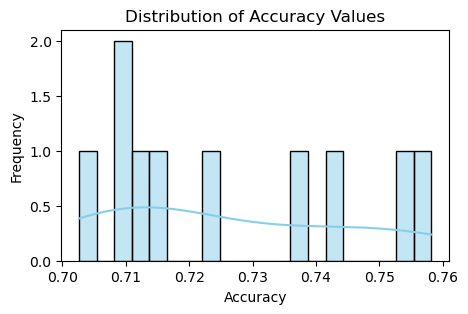

The mean value for the accuracy of Multinomial Bayes is: 72.64705882352942 %
The mean value for the jaccard index is: 56.89157199182407 %
The mean value for the Weighted F1 score for the model is is: 70.46083533248616 %
The mean value for the None weighted F1 score for the model is is: 64.22651156387725 %


In [27]:
classifier_MNB = MultinomialNB()
vectorizer = TfidfVectorizer(max_features=10000)

accuracy_list=[]
f1_science=[]
jaccard_list=[]
f1_all=[]
f1_all_NW=[]


for i in seeds:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=i)
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    classifier_MNB.fit(X_train_tfidf, Y_train)
    y_pred_MNB = classifier_MNB.predict(X_test_tfidf)
    accuracy = accuracy_score(Y_test, y_pred_MNB)
    accuracy_list.append(accuracy)
    weighted_mean_MNB = np.average(accuracy_list)
    
    f1 = f1_score(Y_test, y_pred_MNB, average=None)[7]
    f1_science.append(f1)
    
    f1_1 = f1_score(Y_test, y_pred_MNB, average='weighted')
    f1_all.append(f1_1)
    mean_f1_all_MNB=np.mean(f1_all)
    
    f1_2 = f1_score(Y_test, y_pred_MNB, average=None)
    f1_all_NW.append(f1_2)
    mean_f1_all_NW=np.mean(f1_all_NW)
    
    
    jaccard_index = jaccard_score(Y_test, y_pred_MNB, average='weighted')
    jaccard_list.append(jaccard_index)
    mean_jaccard_MNB=np.mean(jaccard_list)
    
    
plt.figure(figsize=(5, 3))
sns.histplot(accuracy_list, bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Accuracy Values')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()


print('The mean value for the accuracy of Multinomial Bayes is:',weighted_mean_MNB*100,'%')
print('The mean value for the jaccard index is:', mean_jaccard_MNB*100,'%')
print('The mean value for the Weighted F1 score for the model is is:', mean_f1_all_MNB*100,'%')
print('The mean value for the None weighted F1 score for the model is is:', mean_f1_all_NW*100,'%')

#### Change the number of seeds to iterate with to 100 so as to see if the accuracy results will converge more to a normal distribution. 

[67  7 36 15 22 69 24 81 16 96 94 40 13  4 65 21 74 40 23 82 75 75 84 30
 69  1  8 18 43 39 59 46 87 82 58 31 10 89 44  8 74 84 15 93 11 71 96 53
 18  7 14 57 71 55 37 55 65 82 11 16 93 98 19 65 36 92 77 83 31 62 99 44
 92 89 11 87 57 83 81 42 50 67 76 21 21 56 51 72 63 24 76 90 36 10 97 72
 67 36 15 36]


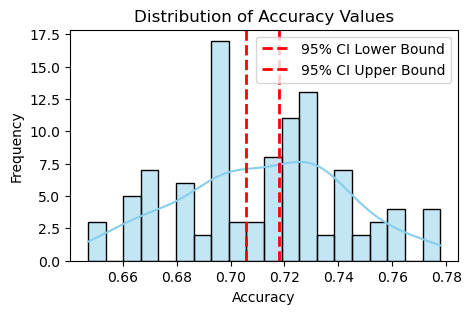

The average accuracy of Multinomial Bayes is: 71.18627450980394 %


In [28]:
#Chnage the number to 100 so as to see if the results will converge to a normal distribution
seeds_1=np.random.randint(1, 100, size=100)
print(seeds_1)

accuracy_list=[]
for i in seeds_1:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=i)
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    classifier_MNB.fit(X_train_tfidf, Y_train)
    y_pred_MNB = classifier_MNB.predict(X_test_tfidf)
    accuracy = accuracy_score(Y_test, y_pred_MNB)
    
    #print(f"Accuracy: {accuracy * 100:.2f}%")
    accuracy_list.append(accuracy)
    weighted_mean = np.average(accuracy_list)
    
#Let's see the 95% confidence interval for seeds=100 for the Multinomial Bayes
confidence_level = 0.95
mean_accuracy = np.mean(accuracy_list)
std_error = np.std(accuracy_list, ddof=1) / np.sqrt(len(accuracy_list))
t_value = t.ppf((1 + confidence_level) / 2, len(accuracy_list) - 1)
confidence_interval = (mean_accuracy - t_value * std_error, mean_accuracy + t_value * std_error)
    
plt.figure(figsize=(5, 3))
sns.histplot(accuracy_list, bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Accuracy Values')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.axvline(confidence_interval[0], color='red', linestyle='dashed', linewidth=2, label='95% CI Lower Bound')
plt.axvline(confidence_interval[1], color='red', linestyle='dashed', linewidth=2, label='95% CI Upper Bound')
plt.legend()
plt.show()
print('The average accuracy of Multinomial Bayes is:',weighted_mean*100,'%')

### 2) Running the the Multinomial Bayes with a single seed and chechking the confision matrix to see possible issue coming from unbalaneced data

##### Evaluation and Confidence Interval Analysis

To gain a more detailed insight, I opted for a **single seed (The Hitchhiker's Guide to the Galaxy number==42) :))))**

I plotted the confusion matrix to identify problematic categories immediately. Two categories stand out: the **Science class** and the **Policy class**.

These observations are evident both in the F1 score, the Confusion Matrix, and, most notably, in the gap between the non-weighted F1 score and accuracy seen previously with 50 seeds. This gap indicates a potential issue with imbalanced data. Higher accuracy coupled with a lower F1 score suggests effective prediction of the majority class but challenges with the minority class.

- **The Science Class**: Appears to be underrepresented with only 60 articles compared to the **Health class** (a common source of confusion) represented by 184 articles. The underrepresentation of the Science class in the training dataset may contribute to the observed results on the heatmap.

- **The Policy Class**: Frequently confused with politics articles, which is more understandable but challenging to address from a data science perspective due to the inherent similarity between the two classes.

##### Proposed Approaches to Tackle Class Imbalance:

**1) Balancing the Dataset by Reducing It (Section 3 of the Multinomial Bayes)<br>
**2) Tunning the Alpha parameter (Section 4 of the Multinomial Bayes)**<br>
**3) Using a Second Model Called Complement Bayes (Model: Complement Bayes)**

Subsequent cells will delve into the exploration of the identified issue and present the confusion matrix.



The accuracy with seed=42: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

     climate       1.00      0.45      0.62        20
     culture       0.85      0.74      0.80        47
      health       0.78      0.76      0.77        51
        life       0.46      0.84      0.59        37
       money       0.74      0.51      0.61        39
      policy       1.00      0.31      0.48        32
    politics       0.52      0.88      0.65        33
     science       0.00      0.00      0.00        14
  technology       0.69      0.94      0.79        33

    accuracy                           0.67       306
   macro avg       0.67      0.60      0.59       306
weighted avg       0.71      0.67      0.65       306

Average Accuracy: 0.6666666666666666
Weighted F1 Score: 0.64589791007859
Non Weighted F1 Score: 0.5897450988008028


C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


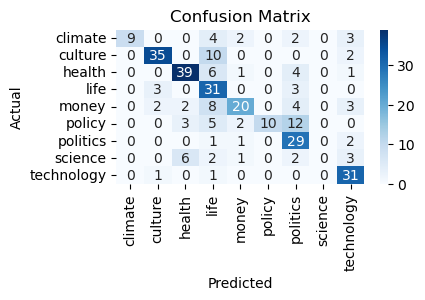

In [29]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
    
classifier_MNB.fit(X_train_tfidf, Y_train)
y_pred_MNB = classifier_MNB.predict(X_test_tfidf)
accuracy = accuracy_score(Y_test, y_pred_MNB)
print('The accuracy with seed=42:',accuracy)

conf_matrix =confusion_matrix(Y_test, y_pred_MNB)

class_labels = sorted(set(Y_test))

classification_rep = classification_report(Y_test, y_pred_MNB, target_names=class_labels)
print("Classification Report:\n", classification_rep)

average_accuracy = accuracy_score(Y_test, y_pred_MNB)
print("Average Accuracy:", average_accuracy)

f1_1 = f1_score(Y_test, y_pred_MNB, average='weighted')
print("Weighted F1 Score:", f1_1)

f1_2 = f1_score(Y_test, y_pred_MNB, average=None)
print("Non Weighted F1 Score:", np.mean(f1_2))



plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

###### Once again we notice a gap between the non weighted F1 and the Accuracy score whcih implies balancing the data so that we can improve the overall perfomance.

In [30]:
check_the_class=df_no_duplicates['Category'].value_counts()
print(check_the_class)

life          226
culture       218
politics      208
technology    202
health        184
money         180
policy        145
climate       106
science        60
Name: Category, dtype: int64


In [31]:
#This is a list with all the F1 scores of the model when ran with the entire dataset (science underrepersted). 
#The different results consider different splits of the data (using 30 different seeds for the random_state)
#We will compare this result to the F1 score when the categories are more equally repersted
print('The F1 score for the category ''Science''when the entire dataset is used: ', f1_science)
f1_score_entire_df=np.mean(f1_science)
print('The mean value for the F1 score for Science is:', f1_score_entire_df)

The F1 score for the category Sciencewhen the entire dataset is used:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
The mean value for the F1 score for Science is: 0.0


### 3) Balancing the Data and Comparing the Results

#### Balancing the Dataset:
Addressing the previously highlighted issue, a new dataset has been created, ensuring each class is represented by exactly 60 instances. The objective is to investigate whether achieving a more balanced class distribution alleviates the 'confusion' issue and leads to an improved F1 score for the 'Science' category and shrinks the gap between Accuracy and Non-weighted F1 score.

##### Nevertheless, the next model in consideration is the Complement Naive Bayes. This model, an adaptation of the traditional Multinomial Naive Bayes classifier, is specifically designed to handle imbalanced datasets.


First I will use a single seed and then I will use iteration to use the list of seeds. 

In this cell, we will see that after equalizing the dataset, the non weighted F1 score and the Accuracy are very similar (the non weighted F1 has increased ), and the accuracy result seems to decrease slightly (due to the dataset reduction). 

Classification Report:
               precision    recall  f1-score   support

     climate       0.92      0.86      0.89        14
     culture       1.00      0.75      0.86        12
      health       0.91      0.53      0.67        19
        life       0.78      0.64      0.70        11
       money       0.40      0.89      0.55         9
      policy       0.64      0.58      0.61        12
    politics       0.85      0.92      0.88        12
     science       0.50      0.75      0.60         8
  technology       1.00      0.91      0.95        11

    accuracy                           0.74       108
   macro avg       0.78      0.76      0.75       108
weighted avg       0.81      0.74      0.75       108

Average Accuracy: 0.6666666666666666
Non weighted F1: 0.7450554616871459
Weighted F1: 0.7518785272266866


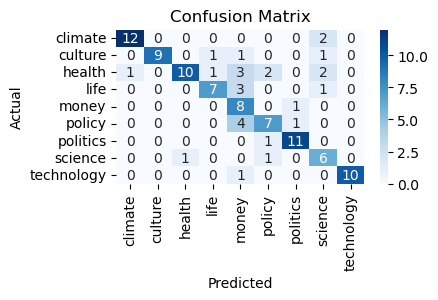

In [32]:
#Create dataset with 60 articles per category
#Single Seed Application of the Multinomial Bayes
new_data=df_no_duplicates

def get_samples(group, num_samples):
    return group.sample(min(len(group), num_samples))

selected_samples = new_data.groupby('Category', group_keys=False, sort=False).apply(get_samples, num_samples=60)

X_60=selected_samples['Content']
Y_60=selected_samples['Category']


#Split the Data 
X_train, X_test, Y_train, Y_test = train_test_split(X_60, Y_60, test_size=0.2, random_state=1)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#Run the model
    
classifier_MNB.fit(X_train_tfidf, Y_train)
y_pred_MNB = classifier_MNB.predict(X_test_tfidf)

accuracy = accuracy_score(Y_test, y_pred_MNB)
f1_1=f1_score(Y_test, y_pred_MNB, average=None)
f1_2=f1_score(Y_test, y_pred_MNB, average='weighted')


#Confusion Matrix

conf_matrix =confusion_matrix(Y_test, y_pred_MNB)

class_labels = sorted(set(Y_test))

classification_rep = classification_report(Y_test, y_pred_MNB, target_names=class_labels)
print("Classification Report:\n", classification_rep)

print("Average Accuracy:", average_accuracy)
print("Non weighted F1:", np.mean(f1_1))
print("Weighted F1:", f1_2)



plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


##### Once again we are using a loop so as to iterate multiple times and split the data with different seeds so as to reduce the impact of the seed choice. (We are using the generated list of seeds we used previously). 

In [33]:
accuracy_list=[]
f1_score_science_60=[]
f2_all=[]
f1_all=[]

for i in seeds:
    X_train, X_test, Y_train, Y_test = train_test_split(X_60, Y_60, test_size=0.2, random_state=i)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    classifier_MNB.fit(X_train_tfidf, Y_train)
    y_pred_MNB = classifier_MNB.predict(X_test_tfidf)
    
    accuracy = accuracy_score(Y_test, y_pred_MNB)
    accuracy_list.append(accuracy)
    weighted_mean = np.average(accuracy_list)
    
    #F1 for the Science Class
    f1 = f1_score(Y_test, y_pred_MNB, average=None)[7]
    f1_score_science_60.append(f1)
    f1_score_science_60_mean=np.mean(f1_score_science_60)
    
    #Non weighted F1 for all classes
    f1_1 = f1_score(Y_test, y_pred_MNB, average=None)
    f1_all.append(f1_1)
    mean_f1_all=np.mean(f1_all)
    
    #Weghted F1 for all classes
    f1_2 = f1_score(Y_test, y_pred_MNB, average='weighted')
    f2_all.append(f1_2)
    mean_f2_all=np.mean(f2_all) 
    
    #Jaccard Index
    jaccard_index = jaccard_score(Y_test, y_pred_MNB, average='weighted')
    jaccard_list.append(jaccard_index)
    mean_jaccard=np.mean(jaccard_list)
    
    
print('The mean value for the accuracy of Multinomial Bayes is:',weighted_mean*100,'%')
print('The mean value for the jaccard index is:', mean_jaccard*100,'%')
print('The mean value for the non weighted F1 score for the model is is:', mean_f1_all*100,'%')
print('The mean value for the weighted F1 score for the model is is:', mean_f2_all*100,'%')
    


The mean value for the accuracy of Multinomial Bayes is: 68.98148148148148 %
The mean value for the jaccard index is: 55.44469814613997 %
The mean value for the non weighted F1 score for the model is is: 68.04490254963065 %
The mean value for the weighted F1 score for the model is is: 68.5714414192805 %


###### We see that the gap between the Accuracy and the non weighted F1 score has shrank significatly.

### Now we will comapre the results between the F1 score for the Science Category before and after equalizing the number of artciles within the dataset to see if this could improve the results of the model. 

In [34]:
print('The mean value of F1 score for the Science category after the sample size for each category is equalized:', f1_score_entire_df)

print('The mean value of F1 score for the Science category after the sample size for each category is equalized:',f1_score_science_60_mean)


The mean value of F1 score for the Science category after the sample size for each category is equalized: 0.0
The mean value of F1 score for the Science category after the sample size for each category is equalized: 0.46649474708298244


###### We see that the improvement is great. The accuracy seems to be slightly lower (for the entire model), but we shall not forget that the size of the dataset was decreased significatly. Additionally from the confusion Matrix we can see that the results for the 'Policy' category have imrpoved also and the accuracy for all the categories seems overall better comapred to the previous case where one category (Science) presented very low values after classification.

This information is impornat because it implies that it is impornat to have the classes equally represented. 

### 4) Tuning the Alpha (Additive Laplace/Lidstone Smoothing) Parameter

In this case, considering the need to drop a great amount of articles because of their belonging to more than one category, there is the need to balance the data. In the previous section, I did this by directly balancing the number of observations for every category.

In this section, I will try to improve the results by tuning the alpha parameter. From theory, we know that a greater value for alpha means more aggressive smoothing, which means that it will help balance the data. Lower values for alpha instead result in less smoothing, making the model more sensitive to the training data. This might be beneficial when you have a large and balanced dataset.

As we already saw, the results with the default value for alpha=1 from section 1 were good. Here we will try to tune the alpha parameter while keeping the seeds and the max_features the same so as to see if lower or higher results of alpha could increase the accuracy, the weighted F1, and the non-weighted F1.

Contrary to what I expected, I see that lower values for alpha increase the results for the model. We see also that the gap between the non-weighted F1 score and the accuracy has shrunk. This is good news even though considering the imbalance in the instances for each class suggested a need for higher alpha.

I ran the model with alpha=0.01 also on the balanced data, however the resulst were very similar to the ones we saw when not tunning the alpha. 




###### Using Grid Search to find the best parameter for alpha and max features

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#Using a pipleine for theTF-IDF vectorizer and Multinomial Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

#Create the Grid dict
#Previously ran the code with much higher values for the alpha 
#It seems that lower values for the alpha work better
param_grid = {'tfidf__max_features': [10000],'mnb__alpha': [0.1, 0.05, 0.01]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print(f"Best Parameters: {best_params}")


Best Parameters: {'mnb__alpha': 0.01, 'tfidf__max_features': 10000}


##### Running the initial code for the Multinomial Bayes with the tunned alpha parameter (in section 1 the alpha param was the default one=1). 



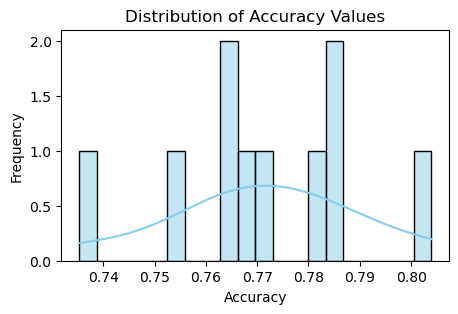

The mean value for the accuracy of Multinomial Bayes is: 77.12418300653594 %
The mean value for the jaccard index is: 63.43691961325884 %
The mean value for the Weighted F1 score for the model is is: 76.78901682860288 %
The mean value for the None weighted F1 score for the model is is: 74.01408007353164 %


In [36]:
classifier_MNB = MultinomialNB(alpha=0.01)
vectorizer = TfidfVectorizer(max_features=10000)

accuracy_list=[]
f1_science=[]
jaccard_list=[]
f1_all=[]
f1_all_NW=[]


for i in seeds:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=i)
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    classifier_MNB.fit(X_train_tfidf, Y_train)
    y_pred_MNB = classifier_MNB.predict(X_test_tfidf)
    accuracy = accuracy_score(Y_test, y_pred_MNB)
    accuracy_list.append(accuracy)
    weighted_mean_MNB = np.average(accuracy_list)
    
    f1 = f1_score(Y_test, y_pred_MNB, average=None)[7]
    f1_science.append(f1)
    
    f1_1 = f1_score(Y_test, y_pred_MNB, average='weighted')
    f1_all.append(f1_1)
    mean_f1_all_MNB=np.mean(f1_all)
    
    f1_2 = f1_score(Y_test, y_pred_MNB, average=None)
    f1_all_NW.append(f1_2)
    mean_f1_all_NW=np.mean(f1_all_NW)
    
    
    jaccard_index = jaccard_score(Y_test, y_pred_MNB, average='weighted')
    jaccard_list.append(jaccard_index)
    mean_jaccard_MNB=np.mean(jaccard_list)
    
    
plt.figure(figsize=(5, 3))
sns.histplot(accuracy_list, bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Accuracy Values')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()


print('The mean value for the accuracy of Multinomial Bayes is:',weighted_mean_MNB*100,'%')
print('The mean value for the jaccard index is:', mean_jaccard_MNB*100,'%')
print('The mean value for the Weighted F1 score for the model is is:', mean_f1_all_MNB*100,'%')
print('The mean value for the None weighted F1 score for the model is is:', mean_f1_all_NW*100,'%')

### 5) Interpretation of the Results from the Multinomial Naive Bayes:

**The following results are based on a single interpretation, and slight variations may occur with each script rerun.**

**Results Obtained Using 50 Different Seeds:**

1. **Multinomial Bayes on the Entire Dataset (1529 Articles, Varied Category Instances):** 

   - Mean Accuracy: 73.88%
   - Mean Jaccard Index: 58.69%
   - Mean Weighted F1 Score: 72.20%
   - Mean Non-weighted F1 Score: 66.58%

2. **Multinomial Bayes on Reduced Dataset (540 Articles, Equal Instances per Category):** 

   - Mean Accuracy: 71.92592592592592 %
   - Mean Jaccard Index: 60.36521032287598 %
   - Mean Non-weighted F1 Score: 71.22025677484838 %
   - Mean Weighted F1 Score: 71.824390323702 %
   
3. **Multinomial Bayes on the Entire Dataset with Tuned Alpha:**

    - Mean Accuracy: 76.79%
    - Mean Jaccard Index: 63.08%
    - Mean Weighted F1 Score: 76.54%
    - Mean Non-weighted F1 Score: 73.57%

   **Observations:**
   - As anticipated, reducing the dataset to equalize class instances leads to a decrease in accuracy. However, there is a substantial increase in the F1 score for the previously low-scoring category (Science).
   - Notably, the gap between the F1 non-weighted score and accuracy has significantly narrowed.
   - The best perfomance of the model is presented after tunning the alpha parameter(alpha=0.01) and the vectorizer to max features=10000.
   - I ran the model also with two explanatory variables (Content and Author), however the results after adding the Author variable were lower, therefore I removed it as a variable in this model. Considering the length of the Multinomial Bayes section (and that it might become confusing), I removed the code, however in the next models, you will see also the presence of Author as an explanatory variable. 

   **Conclusion:**
   - For the Comparson between models I am taking the best performing Multinomial Bayes: 
   Explanatory Variable: Content <br>
   Parameters Model: alphs=0.01 <br>
   Vectorizer parameter: max_features=10000   


### ..................................................................................................................................................................................

# Complement Naive Bayes: 

### Explanatory Variable: Content 
### Dependent Variable: Category

#### 1) Run the Complement Bayes on the unbalanced data (with 50 different seeds)
#### 2) Interpretation of the Results of the Complement Naive Bayes
#### 3) Plot a Comparison of the Results: Complement Naive Bayes vs. Multinomial Naive Bayes

Complement Naive Bayes is an adaptation of the traditional Multinomial Naive Bayes classifier that is designed to handle imbalanced datasets. It was introduced to address the issue of class imbalance, therefore I will apply this model to the entire dataset, to see if the results will improve. 

### 1) Run the Complement Bayes on the unbalanced data (with 50 different seeds). 

Setting the alpha=0.01

Also in this case I ran the code with different values for the alpha, however also i this case the 0.01 is the value that provides the highest results.

###### Check if the tunned value of alpha and max_features parameters is the same as for the Multinomial Bayes.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#Using a pipleine for theTF-IDF vectorizer and Multinomial Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', ComplementNB())
])

#Create the Grid dict
#Previously ran the code with much higher values for the alpha 
#It seems that lower values for the alpha work better
param_grid = {'tfidf__max_features': [10000],'mnb__alpha': [0.1, 0.05, 0.01, 1, 0.5]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print(f"Best Parameters: {best_params}")


Best Parameters: {'mnb__alpha': 0.01, 'tfidf__max_features': 10000}


[697 698 426 340 142 438 325 604 999 870]


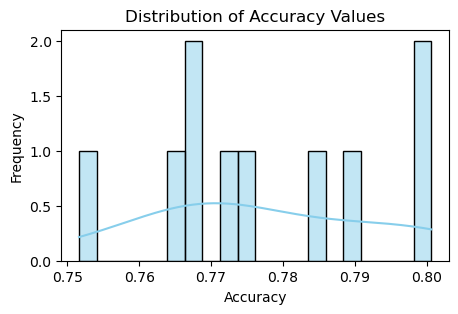

The mean value for the accuracy is: 77.74509803921569 %
The mean value for the jaccard index is: 63.79605079563241 %
The mean value for the non weighted F1 score for the model is is: 72.4944494748905 %
The mean value for the weighted F1 score for the model is is: 76.71647339660733 %


In [38]:

print(seeds)
classifier_CNB = ComplementNB(alpha=0.01)
vectorizer = TfidfVectorizer(max_features=10000)

accuracy_list=[]
f1_science=[]
jaccard_list=[]
f1_all=[]
f1_all_1=[]


for i in seeds:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=i)
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    classifier_CNB.fit(X_train_tfidf, Y_train)
    y_pred_CNB = classifier_CNB.predict(X_test_tfidf)
    accuracy = accuracy_score(Y_test, y_pred_CNB)
    accuracy_list.append(accuracy)
    weighted_mean = np.average(accuracy_list)
    
    f1_1 = f1_score(Y_test, y_pred_CNB, average=None)
    f1_all.append(f1_1)
    mean_f1_all=np.mean(f1_all)
    
    f1_1_1=f1_score(Y_test, y_pred_CNB, average='weighted')
    f1_all_1.append(f1_1_1)
    mean_f1_all_1=np.mean(f1_all_1)
    
    
    jaccard_index = jaccard_score(Y_test, y_pred_CNB, average='weighted')
    jaccard_list.append(jaccard_index)
    mean_jaccard=np.mean(jaccard_list)
    
    
plt.figure(figsize=(5, 3))
sns.histplot(accuracy_list, bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Accuracy Values')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()


print('The mean value for the accuracy is:',weighted_mean*100,'%')
print('The mean value for the jaccard index is:', mean_jaccard*100,'%')
print('The mean value for the non weighted F1 score for the model is is:', mean_f1_all*100,'%')
print('The mean value for the weighted F1 score for the model is is:', mean_f1_all_1*100,'%')


### 2) Interpretation of the Results of the Complement Naive Bayes

Observing the performance of the Complement Naive Bayes model, we note that the results are very similar to the ones presented by the Multinomial Bayes. 

Additional Information: I wan the model when the alpha was not tunned and then teh Complement Bayes perfomred slightly better than the Multionomail Bayes, however after tunning, the Multinomial Bayes seems to work slightly better. 

### 3) Plot a Comparison of the Results: Complement Naive Bayes vs. Multinomial Naive Bayes

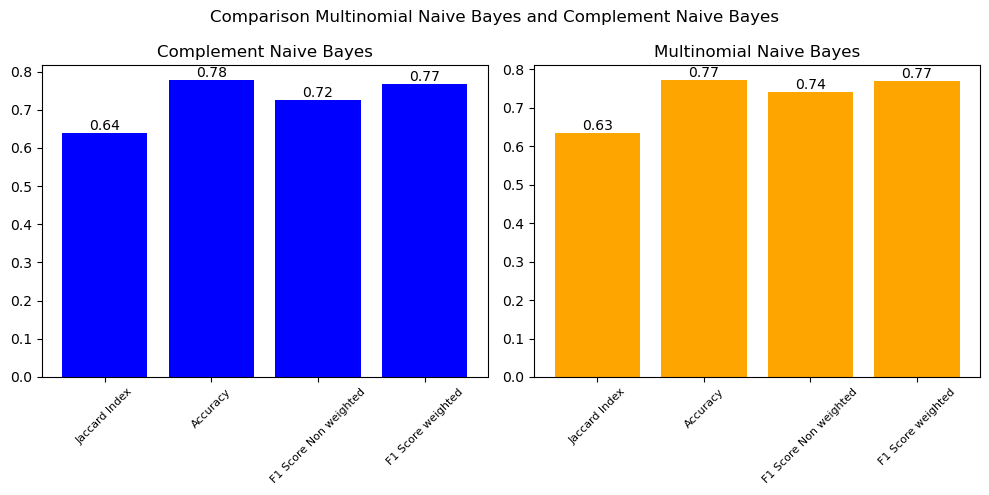

In [39]:
categories = ['Jaccard Index', 'Accuracy', 'F1 Score Non weighted', 'F1 Score weighted']
values1 = [mean_jaccard, weighted_mean, mean_f1_all, mean_f1_all_1]
values2 = [mean_jaccard_MNB, weighted_mean_MNB, mean_f1_all_NW, mean_f1_all_MNB]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

bars1 = ax1.bar(categories, values1, color='blue')
ax1.set_title('Complement Naive Bayes')
for bar, value in zip(bars1, values1):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.00000001, f'{value:.2f}', ha='center', va='bottom')

bars2 = ax2.bar(categories, values2, color='orange')
ax2.set_title('Multinomial Naive Bayes')

for bar, value in zip(bars2, values2):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.00000001, f'{value:.2f}', ha='center', va='bottom')
    
    
ax1.tick_params(axis='x', labelrotation=45, labelsize=8) 
ax2.tick_params(axis='x', labelrotation=45, labelsize=8)  
    
fig.suptitle('Comparison Multinomial Naive Bayes and Complement Naive Bayes')
plt.tight_layout()
plt.show()


### ..................................................................................................................................................................................

# Decision Tree Classification: 

## Explanatory Variable: Content and Author

## Dependent Variable: Category

##### For the Decision Tree Classification I used 3 approaches:

##### 1) Running the model by using Bag-of-words representation rapresentation by using CountVectorizer for the articles'content
##### 2) Running the model by using TF-IDF (Term Frequency-Inverse Document Frequency) (High number of features in the dataset)
##### 3) Plotting a Comparison between 1) and 2)  and comparing the gini and entropy impurity matrices
##### 4) Employing TF-IDF and Dimensionality Reduction by hashing
##### 5) Interpretation of the Results
##### 6) Plot matrices for each approach: comparison results

In [40]:
#Encode the names of the Authors (will be used as an explanatory variable)
label_encoder = LabelEncoder()
    
df_no_duplicates['Author_encoded'] = label_encoder.fit_transform(df_no_duplicates['Author'])
print(df_no_duplicates[['Author', 'Author_encoded']].head())

           Author  Author_encoded
0  Zack Beauchamp             227
1  Zack Beauchamp             227
2  Zack Beauchamp             227
3  Zack Beauchamp             227
4  Jonathan Guyer             104


### 1) Bag-of-Words Representation Using CountVectorizer:

I initiate the bag-of-words representation by employing CountVectorizer, converting the 'Content' variable into a numerical feature vector—a standard technique for representing text data. 

BoW represents text as a numerical feature vector, where each unique word in the text is assigned a unique index or position.

The bag-of-words features are then combined with 'Category' and 'Author_encoded' from the original DataFrame. This results in the creation of `df_combined`, now featuring columns for each word in the bag-of-words representation, along with 'Category' and 'Author_encoded'. (53927 columns...)

Afterward, I split the data and apply the Decision Tree Model.

Upon observation, the obtained result is notably lower compared to the performance witnessed with the Naive Bayes model.


In [41]:
df_no_duplicates_BOW=df_no_duplicates
corpus = df_no_duplicates_BOW['Content'].tolist() 
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
dense_array = X.toarray()
df_bow = pd.DataFrame(dense_array, columns=feature_names)
df_combined = pd.concat([df_bow, df_no_duplicates_BOW[['Category', 'Author_encoded']]], axis=1)


X_train, X_test, y_train, y_test = train_test_split(df_combined.drop('Category', axis=1), df_combined['Category'], test_size=0.2, random_state=22)
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1_NW=f1_score(y_test, y_pred, average=None)
print("F1 non weighted:", np.mean(f1_NW))

f1_W=f1_score(y_test, y_pred, average='weighted')
print("F1 weighted:", f1_W)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

df_combined.shape

Accuracy: 0.565359477124183
F1 non weighted: 0.5394334084527395
F1 weighted: 0.5645170113452754

Classification Report:
              precision    recall  f1-score   support

     climate       0.62      0.59      0.60        27
     culture       0.62      0.69      0.65        42
      health       0.70      0.47      0.56        30
        life       0.56      0.63      0.59        43
       money       0.49      0.58      0.53        36
      policy       0.37      0.45      0.41        29
    politics       0.62      0.51      0.56        47
     science       0.38      0.25      0.30        12
  technology       0.65      0.65      0.65        40

    accuracy                           0.57       306
   macro avg       0.56      0.54      0.54       306
weighted avg       0.57      0.57      0.56       306


Confusion Matrix:
[[16  2  1  2  3  1  1  0  1]
 [ 0 29  0  6  2  2  1  0  2]
 [ 1  1 14  3  2  8  1  0  0]
 [ 1  4  1 27  2  2  4  1  1]
 [ 1  4  0  3 21  2  1  0  4]
 [ 0  

(1529, 53927)

##### Also in this case, I did not run the cross validation of the model because of the default value for the parmeters for the model: 

- `criterion`: 'gini'
- `splitter`: 'best'
- `max_depth`: None
- `min_samples_split`: 2
- `min_samples_leaf`: 1
- `max_features`: None

I did however levarge on the possbility of chaning the impurity parameter (criterion).

##### Running the code by interating for different values of the seed to possbly get more robust results

In [42]:
BOW_DT_accuracy_results_gini = []
BOW_DT_f1_results_gini = []
BOW_DT_f1_Nweighted_gini = []

BOW_DT_accuracy_results_entropy = []
BOW_DT_f1_results_entropy = []
BOW_DT_f1_Nweighted_entropy = []

for i in seeds:
    X_train, X_test, y_train, y_test = train_test_split(df_combined.drop('Category', axis=1), df_combined['Category'], test_size=0.2, random_state=i)
    
    #decision tree model with gini
    tree_gini = DecisionTreeClassifier(criterion='gini')
    tree_gini.fit(X_train, y_train)
    y_pred_gini = tree_gini.predict(X_test)

#Accuracy, F1 weighted, F1 non weighted
    accuracy_gini = accuracy_score(y_test, y_pred_gini)
    BOW_DT_accuracy_results_gini.append(accuracy_gini)

    f1_gini = f1_score(y_test, y_pred_gini, average='weighted')
    BOW_DT_f1_results_gini.append(f1_gini)

    f1_NW_gini = f1_score(y_test, y_pred_gini, average=None)
    BOW_DT_f1_Nweighted_gini.append(f1_NW_gini)
    
    #decision tree model with entropy
    tree_entropy = DecisionTreeClassifier(criterion='entropy')
    tree_entropy.fit(X_train, y_train)
    y_pred_entropy = tree_entropy.predict(X_test)


    accuracy_entropy = accuracy_score(y_test, y_pred_entropy)
    BOW_DT_accuracy_results_entropy.append(accuracy_entropy)

    f1_entropy = f1_score(y_test, y_pred_entropy, average='weighted')
    BOW_DT_f1_results_entropy.append(f1_entropy)

    f1_NW_entropy = f1_score(y_test, y_pred_entropy, average=None)
    BOW_DT_f1_Nweighted_entropy.append(f1_NW_entropy)


print("Results for Gini:")
print("Mean Accuracy:", np.mean(BOW_DT_accuracy_results_gini))
print("Mean weighted F1 Score:", np.mean(BOW_DT_f1_results_gini))
print("F1 non weighted:", np.mean(BOW_DT_f1_Nweighted_gini))

#\n for new line
print("\nResults for Entropy:")
print("Mean Accuracy:", np.mean(BOW_DT_accuracy_results_entropy))
print("Mean weighted F1 Score:", np.mean(BOW_DT_f1_results_entropy))
print("F1 non weighted:", np.mean(BOW_DT_f1_Nweighted_entropy))


Results for Gini:
Mean Accuracy: 0.5598039215686275
Mean weighted F1 Score: 0.5566584765196254
F1 non weighted: 0.5264655893868642

Results for Entropy:
Mean Accuracy: 0.5392156862745099
Mean weighted F1 Score: 0.5356347899526932
F1 non weighted: 0.5019415661578946


### 2) TF-IDF (Term Frequency-Inverse Document Frequency) (High number of features in the dataset)

TF-IDF also represents text as a numerical feature vector, but it addresses the issue of word importance.

Term Frequency (TF): Represents the frequency of a word in a document. It helps in understanding how often a word appears in an article.
Inverse Document Frequency (IDF): Penalizes words that are too common across all articles. It gives higher weight to words that are unique to a specific article.

The scope is to see if the result will be higher compared to the Bag-of-Words Representation Using CountVectorizer approach. 

(In the third section the TF-IDF will be explianed better also by demostrating the dataset) 

It is impornat to mention that similarrly to the Bag-of-Words Representation, also the  TF-IDF approach of reperseing the textual data in terms of numbers creates a dataset with very high dimesionality (one column for each max features=2000). 

In the third section about Decision Tree I will apply a different (more freestyle) approach so as to reduce the dimesions of the dataset that is used for traing the model.



In [43]:
content_corpus = df_no_duplicates_BOW['Content'].tolist()
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(content_corpus)

feature_names = vectorizer.get_feature_names_out()
dense_array = X.toarray()
df_tfidf = pd.DataFrame(dense_array, columns=feature_names)
#Using df_no_duplicates_BOW[['Category', 'Author_encoded']] because it consists only of the columns we need
df_combined_tfidf = pd.concat([df_tfidf, df_no_duplicates_BOW[['Category', 'Author_encoded']]], axis=1)

TFIDF_DT_accuracy_results_gini = []
TFIDF_DT_f1_results_gini = []
TFIDF_DT_f1_Nweighted_gini = []

TFIDF_DT_accuracy_results_entropy = []
TFIDF_DT_f1_results_entropy = []
TFIDF_DT_f1_Nweighted_entropy = []


##### To see the dimensionality. As we remember there is 1 column for each element from the max features and additionally we have the Author and the Category columns.

In [44]:
print(df_combined_tfidf.shape)

(1529, 2002)


In [45]:
for i in seeds:
    X_train, X_test, y_train, y_test = train_test_split(df_combined_tfidf.drop('Category', axis=1), df_combined_tfidf['Category'], test_size=0.2, random_state=i)
    
    #Decision tree model with gini
    tree_classifier_gini = DecisionTreeClassifier(criterion='gini', max_depth= None, min_samples_split=4, min_samples_leaf=10)
    tree_classifier_gini.fit(X_train, y_train)
    y_pred_gini = tree_classifier_gini.predict(X_test)

    #Evaluate the model with gini
    accuracy_gini = accuracy_score(y_test, y_pred_gini)
    TFIDF_DT_accuracy_results_gini.append(accuracy_gini)

    f1_gini = f1_score(y_test, y_pred_gini, average='weighted')
    TFIDF_DT_f1_results_gini.append(f1_gini)

    f1_NW_gini = f1_score(y_test, y_pred_gini, average=None)
    TFIDF_DT_f1_Nweighted_gini.append(f1_NW_gini)
    
    #Decision tree model with entropy
    tree_classifier_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
    tree_classifier_entropy.fit(X_train, y_train)
    y_pred_entropy = tree_classifier_entropy.predict(X_test)

    #Evaluate the model with entropy
    accuracy_entropy = accuracy_score(y_test, y_pred_entropy)
    TFIDF_DT_accuracy_results_entropy.append(accuracy_entropy)

    f1_entropy = f1_score(y_test, y_pred_entropy, average='weighted')
    TFIDF_DT_f1_results_entropy.append(f1_entropy)

    f1_NW_entropy = f1_score(y_test, y_pred_entropy, average=None)
    TFIDF_DT_f1_Nweighted_entropy.append(f1_NW_entropy)
print("Results with gini as impurity as imourity param:")
print("Mean Accuracy:", np.mean(TFIDF_DT_accuracy_results_gini))
print("Mean weighted F1 Score:", np.mean(TFIDF_DT_f1_results_gini))
print("F1 non weighted:", np.mean(TFIDF_DT_f1_Nweighted_gini))

print("\nResults with Entropy as impurity param:")
print("Mean Accuracy:", np.mean(TFIDF_DT_accuracy_results_entropy))
print("Mean weighted F1 Score:", np.mean(TFIDF_DT_f1_results_entropy))
print("F1 non weighted:", np.mean(TFIDF_DT_f1_Nweighted_entropy))



Results with gini as impurity as imourity param:
Mean Accuracy: 0.5647058823529412
Mean weighted F1 Score: 0.5617615253575302
F1 non weighted: 0.5350911388657908

Results with Entropy as impurity param:
Mean Accuracy: 0.5130718954248366
Mean weighted F1 Score: 0.5124465471687677
F1 non weighted: 0.4855301654375323


### 3) Plotting a Comparison between 1) and 2)  and comparing the gini and entropy impurity matrices

The comparison between **Gini** and **Entropy** impurity matrices reveals that the **Gini** impurity matrix performs better in both cases. Consequently, we opt to use the **Gini** impurity matrix to represent the results from the Decision Tree.

In the following section, a visual comparison is presented, highlighting the differences between two distinct approaches employed for the numerical representation of article content. Despite both approaches demonstrating effectiveness, the **Bag-of-Words (BoW)** approach appears slightly superior (depending also on the seeds).

However, it's essential to address the challenge of high dimensionality resulting from the methods we just saw . In the next section **(4)**, an alternative approach will be explored to tackle the issue of large dimensionality (render the dataset less complex) that is created by this process:

```python
feature_names = vectorizer.get_feature_names_out()
dense_array = X.toarray()
df_tfidf = pd.DataFrame(dense_array, columns=feature_names)

that is created by this process:




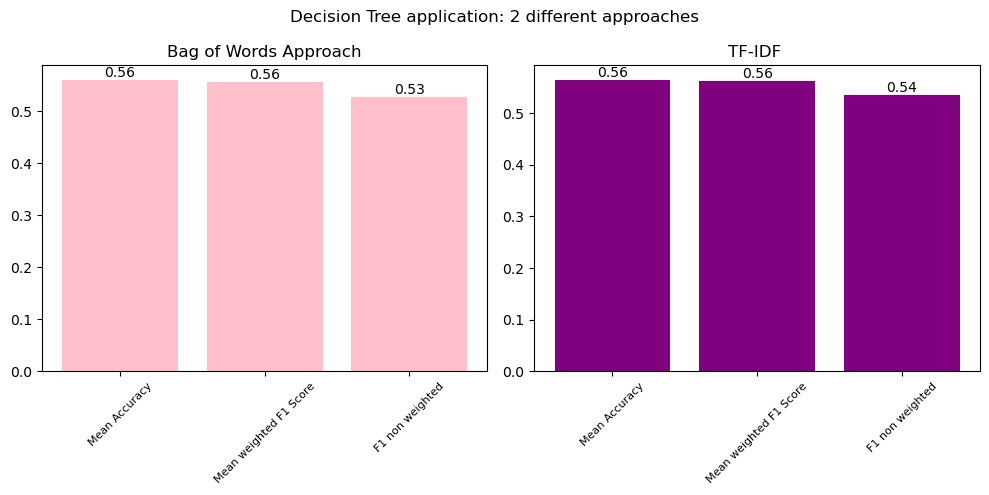

In [46]:
categories = ["Mean Accuracy", "Mean weighted F1 Score", "F1 non weighted"]
values1 = [np.mean(BOW_DT_accuracy_results_gini) , np.mean(BOW_DT_f1_results_gini) , np.mean(BOW_DT_f1_Nweighted_gini)]
values2 = [np.mean(TFIDF_DT_accuracy_results_gini),np.mean(TFIDF_DT_f1_results_gini), np.mean(TFIDF_DT_f1_Nweighted_gini)]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

bars1 = ax1.bar(categories, values1, color='pink')
ax1.set_title('Bag of Words Approach')
for bar, value in zip(bars1, values1):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.00000001, f'{value:.2f}', ha='center', va='bottom')

bars2 = ax2.bar(categories, values2, color='purple')
ax2.set_title('TF-IDF ')

for bar, value in zip(bars2, values2):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.00000001, f'{value:.2f}', ha='center', va='bottom')
    
    
ax1.tick_params(axis='x', labelrotation=45, labelsize=8) 
ax2.tick_params(axis='x', labelrotation=45, labelsize=8)  
    
fig.suptitle('Decision Tree application: 2 different approaches')
plt.tight_layout()
plt.show()

### 4) Employing TF-IDF and Dimensionality Reduction

1) Given the overwhelming number of columns generated by the bag-of-words approach, I opted for an alternative strategy by leveraging Term Frequency-Inverse Document Frequency (TF-IDF).

I configured the vectorizer with **max features=2000** (`vectorizer = TfidfVectorizer(max_features=2000)`), establishing a vocabulary of the 2000 most prevalent terms across the entire corpus. For each article, this approach creates a list with values either equal to 0 or greater than 0.

   - **TF-IDF = 0:** Denotes that the term either does not appear in the document or is common across all documents in the corpus.
   - **TF-IDF > 0:** Indicates that the term is present in the document, with a higher TF-IDF value signifying increased importance and specificity to that document.

This resulted in new columns that hold an array for each article, capturing the TF-IDF values based on this limited dictionary (**max features=2000**).

2) Recognizing that Decision Trees require scalar values for classification and to maintain a manageable number of columns, I encoded the arrays using the **hashing** function. The arrays were converted to tuples due to their non-hashable nature arising from mutability.

3) Combining the explanatory variables in the **feature_col**, I executed the Decision Tree Models. The achieved results were marginally lower compared to the Bag of Words from NLP.

4) Acknowledging the moderate results (slightly over 50%), I plan to calibrate the model by experimenting with different criteria, with the default being gini.

5) Information Gain assessment will follow to gain deeper insights into the significance of various features.

6) Subsequently, I will rerun the model, considering each explanatory variable individually.


In [47]:
vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf = vectorizer.fit_transform(df_no_duplicates['Content'])

#Creating a new Variable that will contain the TF-IDF representation of each article so that we can use more than variable
df_no_duplicates['tfidf_values'] = pd.Series([row.tolist() for row in X_tfidf.toarray()])


#If you scroll down you will see non-zero values
df_no_duplicates['tfidf_values'][42]


[0.0,
 0.008525713810726235,
 0.0,
 0.0,
 0.0,
 0.020365340247076567,
 0.0,
 0.0,
 0.0,
 0.0,
 0.007107629847746403,
 0.0,
 0.0,
 0.0,
 0.0,
 0.009444966561281935,
 0.0,
 0.0,
 0.0,
 0.006663188850026247,
 0.013880818940810046,
 0.00865899340748903,
 0.0,
 0.0,
 0.0,
 0.0,
 0.008944270743666969,
 0.0,
 0.009873376811160987,
 0.0,
 0.0,
 0.0,
 0.0,
 0.023519712556876432,
 0.0,
 0.0,
 0.0,
 0.0,
 0.010619006500926776,
 0.0,
 0.0161192280002481,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.007004763541114941,
 0.0,
 0.01014226155522192,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.008146921856823629,
 0.010307187458538241,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.009289044400548977,
 0.01101905181100543,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.006863542941792776,
 0.0,
 0.010714239151434282,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.019673633547224054,
 0.0,
 0.0,
 0.0,
 0.008210462196947668,
 0.014490321199398594,
 0.0,
 0

In [48]:
df_no_duplicates['tfidf_values_as_tuples'] = df_no_duplicates['tfidf_values'].apply(tuple)

In [49]:
df_no_duplicates['hash_values'] = df_no_duplicates['tfidf_values_as_tuples'].apply(hash)

In [50]:
df_no_duplicates.columns

Index(['Title', 'Author', 'Category', 'Link', 'Content', 'Author_encoded',
       'tfidf_values', 'tfidf_values_as_tuples', 'hash_values'],
      dtype='object')

In [51]:
df_no_duplicates.hash_values

0      -8482201515852697599
1       7809888413048112726
2        316709692487270274
3      -5955460383696583105
4       1345916426468929131
               ...         
1524   -1597040437789370639
1525   -5337006134074687589
1526   -5361720287479892191
1527    6857942498661718151
1528    1250493336164020337
Name: hash_values, Length: 1529, dtype: int64

###### Application of the Decision Tree Model

In [52]:
feature_col=['Author_encoded', 'hash_values']

X = df_no_duplicates[feature_col] 
y = df_no_duplicates.Category 

We see that the number of columns is much lower when we use this approach.

In [53]:
df_no_duplicates.shape

(1529, 9)

###### First with a single seed

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

tree = DecisionTreeClassifier()

tree = tree.fit(X_train,y_train)

y_pred = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.5228758169934641

Classification Report:
              precision    recall  f1-score   support

     climate       0.71      0.56      0.63        27
     culture       0.72      0.67      0.69        42
      health       0.33      0.43      0.38        30
        life       0.42      0.40      0.41        43
       money       0.52      0.69      0.60        36
      policy       0.25      0.21      0.23        29
    politics       0.48      0.45      0.46        47
     science       0.50      0.17      0.25        12
  technology       0.70      0.82      0.76        40

    accuracy                           0.52       306
   macro avg       0.52      0.49      0.49       306
weighted avg       0.52      0.52      0.52       306


Confusion Matrix:
[[15  1  5  1  1  2  1  0  1]
 [ 0 28  3  7  1  0  1  0  2]
 [ 2  2 13  4  1  4  3  0  1]
 [ 1  4  5 17  5  2  4  0  5]
 [ 0  1  1  4 25  2  2  0  1]
 [ 0  1  2  3  6  6  9  1  1]
 [ 2  1  4  1  6  8 21  1  3]
 [ 1  1  3  2

In [55]:
df_no_duplicates.Category.value_counts()

life          226
culture       218
politics      208
technology    202
health        184
money         180
policy        145
climate       106
science        60
Name: Category, dtype: int64

###### Iterate through different seeds

In [56]:
list_accuracy_DT_gini = []
tfidfF1_DT_gini = []
tfidfF1_DT_NonW_gini = []

list_accuracy_DT_entropy = []
tfidfF1_DT_entropy = []
tfidfF1_DT_NonW_entropy = []

for i in seeds: 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)


    tree_gini = DecisionTreeClassifier(criterion='gini')
    tree_gini = tree_gini.fit(X_train, y_train)
    y_pred_gini = tree_gini.predict(X_test)

    accuracy_gini = accuracy_score(y_test, y_pred_gini)
    list_accuracy_DT_gini.append(accuracy_gini)
    
    f1_gini = f1_score(y_test, y_pred_gini, average='weighted')
    tfidfF1_DT_gini.append(f1_gini)
    
    f1_NonW_gini = f1_score(y_test, y_pred_gini, average=None)
    tfidfF1_DT_NonW_gini.append(f1_NonW_gini)
    

    tree_entropy = DecisionTreeClassifier(criterion='entropy')
    tree_entropy = tree_entropy.fit(X_train, y_train)
    y_pred_entropy = tree_entropy.predict(X_test)

    accuracy_entropy = accuracy_score(y_test, y_pred_entropy)
    list_accuracy_DT_entropy.append(accuracy_entropy)
    
    f1_entropy = f1_score(y_test, y_pred_entropy, average='weighted')
    tfidfF1_DT_entropy.append(f1_entropy)
    
    f1_NonW_entropy = f1_score(y_test, y_pred_entropy, average=None)
    tfidfF1_DT_NonW_entropy.append(f1_NonW_entropy)

print("Results for Gini:")
print("Mean Accuracy:", np.mean(list_accuracy_DT_gini))
print("Mean weighted F1 Score:", np.mean(tfidfF1_DT_gini))
print("Mean non-weighted F1 Score:", np.mean(tfidfF1_DT_NonW_gini))

#Results for entropy (just to check)
print("\nResults for Entropy:")
print("Mean Accuracy:", np.mean(list_accuracy_DT_entropy))
print("Mean weighted F1 Score:", np.mean(tfidfF1_DT_entropy))
print("Mean non-weighted F1 Score:", np.mean(tfidfF1_DT_NonW_entropy))


Results for Gini:
Mean Accuracy: 0.5147058823529411
Mean weighted F1 Score: 0.5147086951185732
Mean non-weighted F1 Score: 0.4757596385832526

Results for Entropy:
Mean Accuracy: 0.5169934640522875
Mean weighted F1 Score: 0.5173007671214002
Mean non-weighted F1 Score: 0.4797796968969478


##### We check the information gain: 

In [57]:
print('Information Gain: Author_encoded:',tree_gini.feature_importances_[0])
print('Information Gain: hash_values:',tree_gini.feature_importances_[1])

Information Gain: Author_encoded: 0.546393081920354
Information Gain: hash_values: 0.453606918079646


###### We see that the information gain is  lower  for the hash_values. 
This might be due to the hasing that transforms the data 

##### I decided to run the model with a single variable: Author. 

We see that the result improves. As we know, when we use only one variable in a decision tree, the information gain of that variable directly influences the tree's decision-making process. I do not expect a direct convergence between the Information Gain and the Accuracy (simply becase they are different matreces). We do however see that the values are not far from each other (considering that we are using only 'Author' as an explanatory variable).

In [58]:
X_author=df_no_duplicates['Author_encoded']
y = df_no_duplicates['Category']

list_accuracy_DT=[]
f1_weighted_bucket=[]
f1_nonweighted_bucket=[]

for i in seeds: 
    X_train, X_test, y_train, y_test = train_test_split(X_author, y, test_size=0.2, random_state=i)

    tree = DecisionTreeClassifier(criterion='gini', max_depth= None, min_samples_split=4, min_samples_leaf=10)

    tree.fit(X_train.values.reshape(-1, 1), y_train)  # Reshape X_train to a 2D array with a single column

    y_pred = tree.predict(X_test.values.reshape(-1, 1))

    accuracy=accuracy_score(y_test, y_pred)
    
    f1_weighted=f1_score(y_test, y_pred, average='weighted')
    f1_weighted_bucket.append(f1_weighted)
    
    f1_nonweighted=f1_score(y_test, y_pred, average=None)
    f1_nonweighted_bucket.append(f1_nonweighted)
    
    
    list_accuracy_DT.append(accuracy)
    
print('The mean value for the accuracy is:',np.mean(list_accuracy_DT))
print('The mean value for the weighted F1 score is:',np.mean(f1_weighted_bucket))
print('The mean value for the non-weighted F1 score is:',np.mean(f1_nonweighted_bucket))

The mean value for the accuracy is: 0.5604575163398693
The mean value for the weighted F1 score is: 0.555850590654176
The mean value for the non-weighted F1 score is: 0.5091804131366834


##### For hash_values which represents the content we get low value of accuracy

In [59]:
X_author=df_no_duplicates['hash_values']
y = df_no_duplicates['Category']

list_accuracy_DT=[]
for i in seeds: 
    X_train, X_test, y_train, y_test = train_test_split(X_author, y, test_size=0.2, random_state=i)

    tree = DecisionTreeClassifier()

    tree.fit(X_train.values.reshape(-1, 1), y_train)  # Reshape X_train to a 2D array with a single column

    y_pred = tree.predict(X_test.values.reshape(-1, 1))

    accuracy=accuracy_score(y_test, y_pred)
    
    list_accuracy_DT.append(accuracy)
    
print(np.mean(list_accuracy_DT))

0.1287581699346405


### 5) Interpretation of Results for Decision Tree

Upon scrutinizing the confusion matrices generated for the Decision Tree, a notable observation emerges: categories with lower F1 scores do not always correlate with those underrepresented in the dataset. This suggests that challenges faced by the Decision Tree model extend beyond the simple imbalance of instances in specific categories.

Furthermore, a significant gap between the F1 non-weighted score and accuracy becomes apparent, particularly when employing the TF-IDF and Dimensionality Reduction Approach. This disparity indicates a potential issue arising from the unbalanced nature of the data across different classes.

It's noteworthy that, despite the TF-IDF (High Dimesion) approach being more intricate, it does yield slightly better results compared to the TF-IDF Low Dimension, as evident in the plot in the subsequent cell.

Surprisingly, the model appears to perform better when utilizing a single explanatory variable—the Author's name—although the results are close to those of the Bag-of-Words Representation approach.

To address these concerns and potentially mitigate overfitting, the next step involves applying the Random Forest model.

Crucially, both in terms of accuracy and F1 score, the Decision Tree produces lower results compared to the Multinomial or Complement Naive Bayes models.




### 6) Plot matrices for each approach: TF-IDF (High Dimesional) vs TF-IDF (Low Dimesional) 

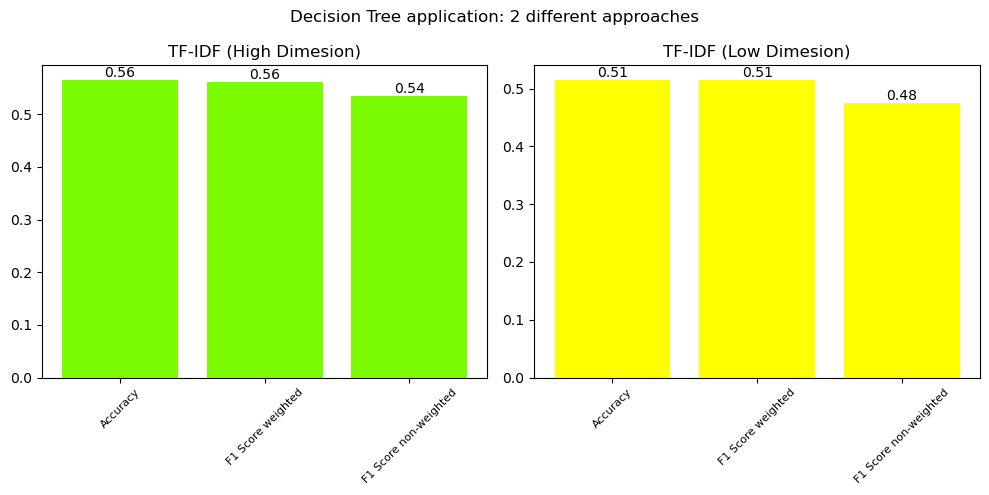

In [60]:
categories = ['Accuracy', 'F1 Score weighted', 'F1 Score non-weighted']
values1 = [np.mean(TFIDF_DT_accuracy_results_gini),np.mean(TFIDF_DT_f1_results_gini), np.mean(TFIDF_DT_f1_Nweighted_gini)]
values2 = [np.mean(list_accuracy_DT_gini),np.mean(tfidfF1_DT_gini),np.mean(tfidfF1_DT_NonW_gini)]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

bars1 = ax1.bar(categories, values1, color='lawngreen')
ax1.set_title('TF-IDF (High Dimesion)')
for bar, value in zip(bars1, values1):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.00000001, f'{value:.2f}', ha='center', va='bottom')

bars2 = ax2.bar(categories, values2, color='yellow')
ax2.set_title('TF-IDF (Low Dimesion)')

for bar, value in zip(bars2, values2):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.00000001, f'{value:.2f}', ha='center', va='bottom')
    
    
ax1.tick_params(axis='x', labelrotation=45, labelsize=8) 
ax2.tick_params(axis='x', labelrotation=45, labelsize=8)  
    
fig.suptitle('Decision Tree application: 2 different approaches')
plt.tight_layout()
plt.show()


### ..................................................................................................................................................................................

# Random Forest: 

## Explanatory Variable: Content and Author

## Dependent Variable: Category

#### 1) Applying the Random Forest by using the CountVectorizer()
#### 2) Applying the Random Forest by using the TfidfVectorizer (High Dimesional)
#### 3) Hyperparameter Tuning: n_estimators
#### 4) Interpretation of the Random Forest model results for Classification

### 1) Applying the Random Forest by using the CountVectorizer()

CountVectorizer() for vectorization of the content explanatory variable. Ran with a high number of subsets (n_estimators=1000) as suggested by the tunning in the 3rd section.

In [61]:
content_corpus_RandForest = df_no_duplicates['Content'].tolist()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(content_corpus_RandForest)
y=df_no_duplicates['Category']

feature_names = vectorizer.get_feature_names_out()
dense_array = X.toarray()
df_tfidf = pd.DataFrame(dense_array, columns=feature_names)
df_combined_tfidf = pd.concat([df_tfidf, df_no_duplicates_BOW[['Category', 'Author_encoded']]], axis=1)

list_accuracy_RF_gini = []
tfidfF1_RF_gini = []
tfidfF1_RF_NonW_gini = []

list_accuracy_RF_entropy = []
tfidfF1_RF_entropy = []
tfidfF1_RF_NonW_entropy = []

for i in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    #Random Forest model with gini paramm for impurity
    rf_classifier_gini = RandomForestClassifier(n_estimators=1000, criterion='gini', random_state=42)
    rf_classifier_gini = rf_classifier_gini.fit(X_train, y_train)
    y_pred_gini = rf_classifier_gini.predict(X_test)

    accuracy_gini = accuracy_score(y_test, y_pred_gini)
    list_accuracy_RF_gini.append(accuracy_gini)

    f1_RF_gini = f1_score(y_test, y_pred_gini, average='weighted')
    tfidfF1_RF_gini.append(f1_RF_gini)

    f1_NonW_RF_gini = f1_score(y_test, y_pred_gini, average=None)
    tfidfF1_RF_NonW_gini.append(f1_NonW_RF_gini)

    #Random Forest Model with entropy paramm for impurity
    rf_classifier_entropy = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
    rf_classifier_entropy = rf_classifier_entropy.fit(X_train, y_train)
    y_pred_entropy = rf_classifier_entropy.predict(X_test)

    accuracy_entropy = accuracy_score(y_test, y_pred_entropy)
    list_accuracy_RF_entropy.append(accuracy_entropy)

    f1_RF_entropy = f1_score(y_test, y_pred_entropy, average='weighted')
    tfidfF1_RF_entropy.append(f1_RF_entropy)

    f1_NonW_RF_entropy = f1_score(y_test, y_pred_entropy, average=None)
    tfidfF1_RF_NonW_entropy.append(f1_NonW_RF_entropy)
print("Results for Random Forest with Gini:")
print("Mean Accuracy:", np.mean(list_accuracy_RF_gini))
print("Mean weighted F1 Score:", np.mean(tfidfF1_RF_gini))
print("Mean non-weighted F1 Score:", np.mean(tfidfF1_RF_NonW_gini))

print("\nResults for Random Forest with Entropy:")
print("Mean Accuracy:", np.mean(list_accuracy_RF_entropy))
print("Mean weighted F1 Score:", np.mean(tfidfF1_RF_entropy))
print("Mean non-weighted F1 Score:", np.mean(tfidfF1_RF_NonW_entropy))


Results for Random Forest with Gini:
Mean Accuracy: 0.7490196078431373
Mean weighted F1 Score: 0.7300719399408768
Mean non-weighted F1 Score: 0.6721642840589778

Results for Random Forest with Entropy:
Mean Accuracy: 0.6937908496732026
Mean weighted F1 Score: 0.6725438779791519
Mean non-weighted F1 Score: 0.618057982397316


### 2) Random Forest with TfidfVectorizer (High Dimesional)

As we also did for the Decison Tree, I will apply also the TfidfVectorizer that takes into account the frequency of a word in a document relative to its frequency in the entire corpus, helping to identify important words in a document. The idea is to see if the approach taken toward the vectorization of the articles could have an impact on the results of the classification (as we saw it does have an effect).

In [75]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(content_corpus_RandForest)

feature_names = vectorizer.get_feature_names_out()
dense_array = X.toarray()
df_tfidf = pd.DataFrame(dense_array, columns=feature_names)
df_combined_tfidf = pd.concat([df_tfidf, df_no_duplicates_BOW[['Category', 'Author_encoded']]], axis=1)

RF_accuracy_results_gini = []
RF_f1_results_gini = []
RF_f1_Nweighted_gini = []

RF_accuracy_results_entropy = []
RF_f1_results_entropy = []
RF_f1_Nweighted_entropy = []

for i in seeds:
    X_train, X_test, y_train, y_test = train_test_split(df_combined_tfidf.drop('Category', axis=1), df_combined_tfidf['Category'], test_size=0.2, random_state=i)

#Random Forest model with gini
    rf_classifier_gini = RandomForestClassifier(n_estimators=1000, criterion='gini', random_state=42)
    rf_classifier_gini.fit(X_train, y_train)
    y_pred_gini = rf_classifier_gini.predict(X_test)


    accuracy_gini = accuracy_score(y_test, y_pred_gini)
    RF_accuracy_results_gini.append(accuracy_gini)

    f1_gini = f1_score(y_test, y_pred_gini, average='weighted')
    RF_f1_results_gini.append(f1_gini)

    f1_NW_gini = f1_score(y_test, y_pred_gini, average=None)
    RF_f1_Nweighted_gini.append(f1_NW_gini)

#Random forest model with entropy
    rf_classifier_entropy = RandomForestClassifier(n_estimators=2000, criterion='entropy', random_state=42)
    rf_classifier_entropy.fit(X_train, y_train)
    y_pred_entropy = rf_classifier_entropy.predict(X_test)


    accuracy_entropy = accuracy_score(y_test, y_pred_entropy)
    RF_accuracy_results_entropy.append(accuracy_entropy)

    f1_entropy = f1_score(y_test, y_pred_entropy, average='weighted')
    RF_f1_results_entropy.append(f1_entropy)

    f1_NW_entropy = f1_score(y_test, y_pred_entropy, average=None)
    RF_f1_Nweighted_entropy.append(f1_NW_entropy)


print("Results for Gini:")
print("Mean Accuracy:", np.mean(RF_accuracy_results_gini))
print("Mean weighted F1 Score:", np.mean(RF_f1_results_gini))
print("F1 non weighted:", np.mean(RF_f1_Nweighted_gini))


print("\nResults for Entropy:")
print("Mean Accuracy:", np.mean(RF_accuracy_results_entropy))
print("Mean weighted F1 Score:", np.mean(RF_f1_results_entropy))
print("F1 non weighted:", np.mean(RF_f1_Nweighted_entropy))


Results for Gini:
Mean Accuracy: 0.757516339869281
Mean weighted F1 Score: 0.7410139890543378
F1 non weighted: 0.6859550911858806

Results for Entropy:
Mean Accuracy: 0.746078431372549
Mean weighted F1 Score: 0.7276506057994544
F1 non weighted: 0.6732379856445879


### 3) Hyperparameter Tuning: n_estimators

As observed earlier, the results obtained with TfidfVectorizer are higher (slightly) . In this section, we focus exclusively on utilizing the TfidfVectorizer to build and evaluate our model.

To assess the impact of the number of trees (subsets selected by bootstrapping) on model performance, we aim to tune the `n_estimators` parameter. The idea is to investigate whether adjusting this hyperparameter can further enhance the results.

After this assessment, I will set a higher or lower parameter for `n_estimators` to the previous cells.

###### Cross-Validation for Model Evaluation

To systematically evaluate the model and improve generalization, we employ cross-validation. Cross-validation is valuable for assessing the model's performance across different subsets of the training data. Additionally, it can contribute to addressing potential imbalances within our dataset.

The overarching goal is to find an optimal configuration for the `n_estimators` parameter that not only maximizes performance but also ensures robustness and generalization capability.


In [63]:
X_train, X_test, y_train, y_test = train_test_split(df_combined_tfidf.drop('Category', axis=1), df_combined_tfidf['Category'], test_size=0.2, random_state=22)

RF_accuracy_results_gini = []
RF_f1_results_gini = []

rf_low = RandomForestClassifier(n_estimators=100, random_state=42)
rf_high = RandomForestClassifier(n_estimators=1000, random_state=42)

f1_weighted_scorer = make_scorer(f1_score, average='weighted')

scores_lownp_accuracy = cross_val_score(rf_low, X_train, y_train, cv=5, scoring='accuracy')
scores_lownp_f1 = cross_val_score(rf_low, X_train, y_train, cv=5, scoring=f1_weighted_scorer)

scores_high_accuracy = cross_val_score(rf_high, X_train, y_train, cv=5, scoring='accuracy')
scores_high_f1 = cross_val_score(rf_high, X_train, y_train, cv=5, scoring=f1_weighted_scorer)


print("Low n_estimators:")
print("Average Accuracy:", np.mean(scores_lownp_accuracy))
print("Average F1 Weighted:", np.mean(scores_lownp_f1))

print("\nHigh n_estimators:")
print("Average Accuracy:", np.mean(scores_high_accuracy))
print("Average F1 Weighted:", np.mean(scores_high_f1))


Low n_estimators:
Average Accuracy: 0.7310137169621947
Average F1 Weighted: 0.7123045495009204

High n_estimators:
Average Accuracy: 0.7473703579792573
Average F1 Weighted: 0.7295588507215669


### 4) Interpretation of the Random Forest model results for Classification

After running the Random Forest model, several key observations have emerged:

###### Impurity Criterion
In terms of impurity, it's noteworthy that the Gini criterion outperforms others in this specific scenario. The choice of impurity criterion can significantly impact the model's performance.

###### Vectorization Technique
When considering vectorization techniques, the TfidfVectorizer stands out as the more effective choice overall. Its performance surpasses other methods, indicating its suitability for this particular dataset and problem.

###### Impact of the Number of Trees in Bootstrapping

In the context of bootstrapping trees from the dataset, an interesting observation emerges: a higher number of trees indeed correlates with improved results, particularly in terms of accuracy and weighted F1 score. The difference is small, however for the sake of precision it is impornat to tune this parameter. 

The analysis suggests that increasing the number of trees in the Random Forest model contributes positively to its predictive performance. This finding aligns with the intuition that a more diverse ensemble of trees can collectively yield better generalization and robustness against overfitting.


###### Model Comparison
Taking into account both common and specific parameters for the models used in this project, the Random Forest model demonstrates superior performance compared to the Decision Tree. Moreover, it exhibits results comparable to those achieved by Naive Bayes and Complement Naive Bayes models and when the Cross Validation is included even better.

###### General Model Comparison
A comprehensive comparison of all models utilized in this project is provided towards the conclusion. This comparison serves to highlight the strengths and weaknesses of each model, aiding in the selection of the most appropriate one for the given task.


### ..................................................................................................................................................................................

# Support Vector Machine

Throughout the entire section you will see the print(dataset.shape), the scope of this line is to see the point to which the code has arrived considering the amount of time it requires

#### 1) Support Vector Machine by applying the linear kernel (using the TfidfVectorizer())  by using both Author and Content as explanatory variables

#### 2)SVM, applied by using the  Radial Basis Function (RBF) kernel and cross validation for checking the best parameters 

#### 3)SVM applied by using the Polynomial kernel

#### 4) Checking if the model performs better when only the Author or the Content Variable is used

#### 5) Interpretation of the SVM results 


### 1) Support Vector Machine by applying the linear kernel (using the TfidfVectorizer())  by using both Author and Content as explanatory variables

I use the 'tunned' parameters for C and gamma that are found in the second section. 

In [76]:

#We are restating the target variable and the expanatory variables for code clarity, code modularity and to avoid 
#effect from the previous modules (considering that we are vectorizing )

X = df_no_duplicates['Content']
Author_encoded = df_no_duplicates['Author_encoded']
Y = df_no_duplicates['Category']

accuracy_SVM_mean=[]
f1W_SVM_mean=[]
f1NW_SVM_mean=[]

seeds_2=[22,1,42]

for i in seeds_2:

    X_train, X_test, Author_train, Author_test, y_train, y_test = train_test_split(X, Author_encoded, Y, test_size=0.2, random_state=i)

#Vectorizingg
    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

#We remember that author is already encoded so we do not vectorize it 
    X_train_combined = hstack((X_train_tfidf, Author_train.values.reshape(-1, 1)))
    X_test_combined = hstack((X_test_tfidf, Author_test.values.reshape(-1, 1)))

#we see that the shape changes becase we have no set the max features for the vectorizer 
#so it uses all the words in the articles according to the split
    print(X_train_combined.shape) 

#Traing the Support Vector Machine 
    svm_model_combined = SVC(kernel='linear', C=10, gamma=0.1)
    svm_model_combined.fit(X_train_combined, y_train)


    y_pred_combined = svm_model_combined.predict(X_test_combined)

    
    accuracy= accuracy_score(y_test, y_pred_combined)
    
    f1_W=f1_score(y_test, y_pred_combined, average='weighted')
    
    f1NW=f1_score(y_test, y_pred_combined, average=None)
    
    accuracy_SVM_mean.append(accuracy)
    f1W_SVM_mean.append(f1_W)
    f1NW_SVM_mean.append(f1NW)
    
    
print(f'Accuracy of the Model (Author and Content as explanatory variables): {np.mean(accuracy_SVM_mean)}')

print(f'The weighted F1 score of the Model (Author and Content as explanatory variables): {np.mean(f1W_SVM_mean)}')

print(f'The non-weighted F1 score of the Model (Author and Content as explanatory variables): {np.mean(f1NW_SVM_mean)}')


(1223, 48703)
(1223, 48358)
(1223, 48378)
Accuracy of the Model (Author and Content as explanatory variables): 0.7701525054466231
The weighted F1 score of the Model (Author and Content as explanatory variables): 0.7652662836358516
The non-weighted F1 score of the Model (Author and Content as explanatory variables): 0.740765560592942


###### These are the resuls when I ran the model with 50 seeds. The execution of the model took around an hour so I will stick to 3 seeds.

Accuracy of the Model (Author and Content as explanatory variables): 0.7767320261437908 <br>
The weighted F1 score of the Model (Author and Content as explanatory variables): 0.7727292418836064 <br> 
The non-weighted F1 score of the Model (Author and Content as explanatory variables): 0.743416446548409 

### 2)SVM, applied by using the  Radial Basis Function (RBF) kernel and cross validation for checking the best parameters

#### To see if our data is better separable by another kernel (that is not linear), I decided to try with the  Radial Basis Function kernel. The scope is to capture complex relationships in the data that a linear model may not be able to represent.

In the beginning I ran the model without setting the parameters C and Gamma. I received very low results ( accuracy<15%). 

After adding the parameters C (C parameter controls the trade-off between achieving a smooth decision boundary and classifying the training points correctly), and Gamma (defines how far the influence of a single training example reaches. Low values mean that the influence is 'far,' and high values mean it is 'close.' In other words, a small gamma will result in a broader decision boundary, while a large gamma will make the decision boundary more dependent on individual data points). 

To understand the best values for these two parameters I decided to use Cross Valuation that allows me to check the best values for these two parameters for the kernel. 

After running the Cross Validation, I found out that the best values are **C=10 and gamma=0.1** (you can find the code down).

In [65]:
for i in seeds_2:

    X_train, X_test, Author_train, Author_test, y_train, y_test = train_test_split(X, Author_encoded, Y, test_size=0.2, random_state=i)

    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    X_train_combined = hstack((X_train_tfidf, Author_train.values.reshape(-1, 1)))
    X_test_combined = hstack((X_test_tfidf, Author_test.values.reshape(-1, 1)))

    print(X_train_combined.shape) 

    svm_model_rbf = SVC()

    param_dict={'C': [0.1, 1, 10],'gamma': [0.01, 0.1, 1]} 
    grid_search = GridSearchCV(svm_model_rbf, param_dict, cv=5, scoring='accuracy')

    grid_search.fit(X_train_combined, y_train)

    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_

    print(f"Best Parameters: {best_params}")

(1223, 48703)
Best Parameters: {'C': 10, 'gamma': 0.1}
(1223, 48358)
Best Parameters: {'C': 10, 'gamma': 0.1}
(1223, 48378)
Best Parameters: {'C': 10, 'gamma': 0.1}


###### Now we will run the SVM by using the RBF kernel and we will set the C=10 and gamma=0.1 as suggested by the Cross Validation to see if the results will be higher than the ones presented by the linear kernel,

In [77]:
accuracy_SVM_mean_RBF=[]
f1W_SVM_mean_RBF=[]
f1NW_SVM_mean_RBF=[]

for i in seeds_2:

    X_train, X_test, Author_train, Author_test, y_train, y_test = train_test_split(X, Author_encoded, Y, test_size=0.2, random_state=i)

#Vectorizingg
    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)


    X_train_combined = hstack((X_train_tfidf, Author_train.values.reshape(-1, 1)))
    X_test_combined = hstack((X_test_tfidf, Author_test.values.reshape(-1, 1)))


    print(X_train_combined.shape) 

#Traing the Support Vector Machine 
    svm_model_combined = SVC(kernel='rbf',C=10, gamma=0.1)
    svm_model_combined.fit(X_train_combined, y_train)


    y_pred_combined = svm_model_combined.predict(X_test_combined)

    
    accuracy= accuracy_score(y_test, y_pred_combined)
    
    f1_W=f1_score(y_test, y_pred_combined, average='weighted')
    
    f1NW=f1_score(y_test, y_pred_combined, average=None)
    
    accuracy_SVM_mean_RBF.append(accuracy)
    f1W_SVM_mean_RBF.append(f1_W)
    f1NW_SVM_mean_RBF.append(f1NW)
    
    
print(f'Accuracy of the Model (Author and Content as explanatory variables): {np.mean(accuracy_SVM_mean_RBF)}')

print(f'The weighted F1 score of the Model (Author and Content as explanatory variables): {np.mean(f1W_SVM_mean_RBF)}')

print(f'The non-weighted F1 score of the Model (Author and Content as explanatory variables): {np.mean(f1NW_SVM_mean_RBF)}')

(1223, 48703)
(1223, 48358)
(1223, 48378)
Accuracy of the Model (Author and Content as explanatory variables): 0.6938997821350762
The weighted F1 score of the Model (Author and Content as explanatory variables): 0.6915219705855454
The non-weighted F1 score of the Model (Author and Content as explanatory variables): 0.6681575564434068


### 3)SVM applied by using the Polynomial kernel

##### From pure interest I decided to apply also the polynomial kernel. We know that high numbeer for the degrees of the polynomial could lead to overfitting and low number could lead to underfitting. 

In [67]:
svm_model_poly = SVC(kernel='poly')

param_dict={'degree':[2, 3, 4, 5]} 

param_search = GridSearchCV(svm_model_poly, param_dict, cv=5, scoring='accuracy')

param_search.fit(X_train_combined, y_train)

best_parameters = param_search.best_params_
best_accuracy = param_search.best_score_

print(f"Best Parameters (degree of the Polynomial): {best_parameters}")
print(f"Best Cross-validated Accuracy for the RF with polynomail kernel: {best_accuracy:}")


Best Parameters (degree of the Polynomial): {'degree': 2}
Best Cross-validated Accuracy for the RF with polynomail kernel: 0.23712947474071594


We see that the results are pretty low when we use the polynomial kernel. The best degree is 2, however we remember that the linear kernel (polynomial of degree=1) was much better in terms of accuracy, so we will limit the polynomial kernel to degrees [2, 3, 4, 5]. 

I tried to apply also the sigmoid kernel, however the results were even lower (compared to the polynomial kernel), therefore removed the cell. 

### 4) Checking if the model performs better when only the Author or the Content Variable is used

###### Only Content

In [79]:
X = df_no_duplicates['Content']
Y = df_no_duplicates['Category']
accuracy_SVM_mean_C = []
f1W_SVM_mean_C = []
f1NW_SVM_mean_C = []

seeds_2 = [22, 1, 42]

for seed in seeds_2:
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train_tfidf, y_train)

    y_pred = svm_model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    f1_W = f1_score(y_test, y_pred, average='weighted')
    f1_NW = f1_score(y_test, y_pred, average=None)

    accuracy_SVM_mean_C.append(accuracy)
    f1W_SVM_mean_C.append(f1_W)
    f1NW_SVM_mean_C.append(np.mean(f1_NW))

print(f'Mean Accuracy: {np.mean(accuracy_SVM_mean_C):}')
print(f'Mean Weighted F1 Score: {np.mean(f1W_SVM_mean_C):}')
print(f'Mean Non-Weighted F1 Score: {np.mean(f1NW_SVM_mean_C):}')


Mean Accuracy: 0.7603485838779956
Mean Weighted F1 Score: 0.754009325499144
Mean Non-Weighted F1 Score: 0.722066681934595


###### Only Author (poor results) 

In [80]:
X = df_no_duplicates['Author_encoded']
Y = df_no_duplicates['Category']
accuracy_SVM_mean_A = []
f1W_SVM_mean_A = []
f1NW_SVM_mean_A = []

seeds_2 = [22, 1, 42]

for seed in seeds_2:
    X_train_author, X_test_author, y_train, y_test = train_test_split(X_author, Y, test_size=0.2, random_state=seed)

    X_train_author = X_train_author.values.reshape(-1, 1)
    X_test_author = X_test_author.values.reshape(-1, 1)


    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train_tfidf, y_train)

    y_pred = svm_model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    f1_W = f1_score(y_test, y_pred, average='weighted')
    f1_NW = f1_score(y_test, y_pred, average=None)

    accuracy_SVM_mean_A.append(accuracy)
    f1W_SVM_mean_A.append(f1_W)
    f1NW_SVM_mean_A.append(np.mean(f1_NW))

print(f'Mean Accuracy: {np.mean(accuracy_SVM_mean_A):}')
print(f'Mean Weighted F1 Score:{np.mean(f1W_SVM_mean_A):}')
print(f'Mean Non-Weighted F1 Score:{np.mean(f1NW_SVM_mean_A):}')

Mean Accuracy: 0.31808278867102396
Mean Weighted F1 Score:0.2987064940950787
Mean Non-Weighted F1 Score:0.27773056027996157


### 5) Interpretation of the SVM results 

**We see that the results generated by the Support Vector Machine Model when we use the _linear kernel_ are quite impressive and are similar to the ones that were exhibited by our best models for now, which are the _Random Forest_ and the _Complement Bayes_.** 

**Additionally, we saw that the choice of the _kernel_ and the parameters for each kernel do change a lot in the results, and we can deduce some information from the shape of the line that could separate and classify our data.**

**We observe that the model works pretty well (_linear kernel_) even when we use the _Content Variable_ singularly, and works much worse when we use the _Author variable_ singularly (opposite from what we saw in the case of _Decision Tree_).**

**Nevertheless, the best results are generated when both variables are present.**




### ..................................................................................................................................................................................

# Logistic Regression


#### 1) Run the Logistic Regression with Content and Author as explanatory variables
#### 2) Hyperparameter tuning by using the Grid Search so as to find the optimial parameters for tunning 
#### 3) Running the tunned Logistic Regression with a single explanatory Variable 
#### 4) Interpretation of Results 

### 1) Run the Logistic Regression with Content and Author as explanatory variables

The Regression will be ran with the resuts we get from Section 2, namely the best parameters for tunning the model. 

Additional infomarion regarding the tunning will be given in the Second Section. 

In [70]:
X_content = df_no_duplicates['Content']
X_author = df_no_duplicates['Author_encoded']
Y = df_no_duplicates['Category']

accuracy_LR_mean=[]
f1_LR_W_mean=[]
f1_LR_NW_mean=[]
f1_science_mean=[]

for i in seeds:
    X_content_train, X_content_test, X_author_train, X_author_test, y_train, y_test = train_test_split(
        X_content, X_author, Y, test_size=0.2, random_state=42
    )

    #Vecoriziiiiing
    tfidf_vectorizer = TfidfVectorizer()
    X_content_train_tfidf = tfidf_vectorizer.fit_transform(X_content_train)
    X_content_test_tfidf = tfidf_vectorizer.transform(X_content_test)

    #Combine the two explanatory variables (Content needed vectorization), Author already encoded
    X_train_combined = hstack((X_content_train_tfidf, X_author_train.values.reshape(-1, 1)))
    X_test_combined = hstack((X_content_test_tfidf, X_author_test.values.reshape(-1, 1)))

    logistic_regression_model = LogisticRegression(C=600, penalty='l2')

    logistic_regression_model.fit(X_train_combined, y_train)

    y_pred = logistic_regression_model.predict(X_test_combined)
    
    
    

#F1 score and Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    f1_W=f1_score(y_test, y_pred, average='weighted')
    f1_NW=f1_score(y_test, y_pred, average=None)
    f1_science=f1_score(y_test, y_pred, average=None)[7]
    
    
    f1_LR_W_mean.append(f1_W)
    f1_LR_NW_mean.append(f1_NW)
    accuracy_LR_mean.append(accuracy)
    f1_science_mean.append(f1_science)
    

print(f'The mean value for the accuracy for the Logistic Regression is: {np.mean(accuracy_LR_mean)}')
      
print(f'The mean value for the weighted F1 score for the Logistic Regression is: {np.mean(f1_LR_W_mean)}')
      
print(f'The mean value for the non-weighted F1 score for the Logistic Regression is: {np.mean(f1_LR_NW_mean)}')

print(f'The mean value for the non-weighted F1 for the Science category for the Logistic Regression is: {np.mean(f1_science_mean)}')
      


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

The mean value for the accuracy for the Logistic Regression is: 0.673202614379085
The mean value for the weighted F1 score for the Logistic Regression is: 0.6773016786164174
The mean value for the non-weighted F1 score for the Logistic Regression is: 0.6513137240824349
The mean value for the non-weighted F1 for the Science category for the Logistic Regression is: 0.33333333333333337


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 2) Hyperparameter tuning by using the Grid Search so as to find the optimial parameters for tunning 

**The C parameter** determines the trade-off between fitting the training data well and having small coefficients. Lower values for the C result in stronger regularization, which is used to prevent for ovefitting. **Larger Values for C** instead reduce the effect of regularization, allowing the model to be more flexible in fitting the training data. High levels of C might lead to ovefitting. 

Initially I we defined the grid of parameters in a different way. I set smaller values for the C. The highest value was 100. After seeing that the best parameter was C=100, I changed the grid by starting from 100. The idea was to see the marginal point (the point where the accuracy stops to increase) and the effect of overfitting starts to be demostrsted in the accuracy result. 

We see that the value of 600 is the best for the C parameter. 

Additionally in the Grid Search I included the Penalty (Type of Regularization). The one that seems to provide for better results is the penalty='l2' which corresponds to L2 regularization(Ridge), where the squared values of the coefficients are added to the loss function.


**Interpreation of the results before and after tunning:**

***When the Logistic Regression is ran with the default parameters (C=1):***

The mean value for the accuracy for the Logistic Regression is: 0.6241830065359477<br>
The mean value for the weighted F1 score for the Logistic Regression is: 0.6066818336054224<br>
The mean value for the non-weighted F1 score for the Logistic Regression is: 0.5662196832210968<br>
The mean value for the non-weighted F1 for the Science category for the Logistic Regression is: 0.0<br>

***When the Logistic Regression is ran with runned parameters (C=600, penalty='l2'):***

The mean value for the accuracy for the Logistic Regression is: 0.6732026143790851<br>
The mean value for the weighted F1 score for the Logistic Regression is: 0.6773016786164174<br>
The mean value for the non-weighted F1 score for the Logistic Regression is: 0.6513137240824349<br>
The mean value for the non-weighted F1 for the Science category for the Logistic Regression is: 0.33333333333333326<br>

First of all, what is interesting to notice is that we immediately notice that after tunning the parameters, the gap between the non weighted F1 score and the Accuracy becomes much smaller (comapred to the previous results that I received before tunning the model). Additionally we see that the F1 score for the minority category 'Science' is higher when the parameters are tunned. 

This is due to the **C parameter** and its high value in this case **( we set the value of C to 600 and the default one is 1)**. As we know smaller values of C result in stronger regularization, which means the model is more focused on simpler decision boundaries and avoiding fitting noise in the data. In the context of imbalanced data, this regularization can affect the ability of the model to capture the patterns in the minority class. Therefore in this case the C parameter helps us to reduce the effect of the inbalance in the data . 




In [71]:
#Performing the Grid Search to get the best parameters for the Logitic Regression

param_grid = {
    'C': [100, 200, 600, 650, 800],  'penalty': ['l1', 'l2'],}

logistic_regression_model = LogisticRegression()

grid_search = GridSearchCV(logistic_regression_model, param_grid, cv=5, scoring='accuracy')

X_content_train, X_content_test, X_author_train, X_author_test, y_train, y_test = train_test_split(
    X_content, X_author, Y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_content_train_tfidf = tfidf_vectorizer.fit_transform(X_content_train)
X_content_test_tfidf = tfidf_vectorizer.transform(X_content_test)

X_train_combined = hstack((X_content_train_tfidf, X_author_train.values.reshape(-1, 1)))
X_test_combined = hstack((X_content_test_tfidf, X_author_test.values.reshape(-1, 1)))

grid_search.fit(X_train_combined, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_combined)

accuracy = accuracy_score(y_test, y_pred)

print(f'Classification with tuned parameters:\n{classification_report(y_test, y_pred)}')


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best Parameters: {'C': 600, 'penalty': 'l2'}
Classification with tuned parameters:
              precision    recall  f1-score   support

     climate       0.93      0.70      0.80        20
     culture       0.76      0.79      0.77        47
      health       0.84      0.73      0.78        51
        life       0.55      0.73      0.63        37
       money       0.72      0.54      0.62        39
      policy       0.38      0.66      0.48        32
    politics       0.65      0.61      0.62        33
     science       0.75      0.21      0.33        14
  technology       0.87      0.79      0.83        33

    accuracy                           0.67       306
   macro avg       0.72      0.64      0.65       306
weighted avg       0.71      0.67      0.68       306



C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 3) Running the tunned Logistic Regression with a single explanatory Variable 

###### Explanatory Variable: Content (the text of the articles); Target Variable: Category of the article (as for the entire project)


After having found the right parameters for tunning the model, I decided to run the Regression Model by using the two explanatory variables we have at hand (Author and Content) to see if the results could improve. What you can see in the next cells is that the model gives much better results when ran with the Content variable singularly. This means that the Content variable is much more informative in this case. Moreover it might be that the addition of the Author variable leads to overfitting and reduces the cabaility of the model to generalize. 


In [72]:
# Retstaing the Variables because we are again trying to perfrom some variable engeneering 
#To see if possible the model will perform better with a single variable (as the Decision Tree sometimes)
X_content = df_no_duplicates['Content']
Y = df_no_duplicates['Category']

accuracy_LR_mean = []
f1_LR_W_mean = []
f1_LR_NW_mean = []

for seed in seeds:
    X_content_train, X_content_test, y_train, y_test = train_test_split(
        X_content, Y, test_size=0.2, random_state=seed)
    tfidf_vectorizer = TfidfVectorizer()
    X_content_train_tfidf = tfidf_vectorizer.fit_transform(X_content_train)
    X_content_test_tfidf = tfidf_vectorizer.transform(X_content_test)

    logistic_regression_model = LogisticRegression(C=600, penalty='l2')
    logistic_regression_model.fit(X_content_train_tfidf, y_train)

    y_pred = logistic_regression_model.predict(X_content_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    f1_W = f1_score(y_test, y_pred, average='weighted')
    f1_NW = f1_score(y_test, y_pred, average=None)

    f1_LR_W_mean.append(f1_W)
    f1_LR_NW_mean.append(np.mean(f1_NW))
    accuracy_LR_mean.append(accuracy)

print(f'Mean Accuracy: {np.mean(accuracy_LR_mean)}')
print(f'Mean Weighted F1 Score: {np.mean(f1_LR_W_mean)}')
print(f'Mean Non-Weighted F1 Score: {np.mean(f1_LR_NW_mean)}')


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Mean Accuracy: 0.7833333333333334
Mean Weighted F1 Score: 0.7796043233195119
Mean Non-Weighted F1 Score: 0.7540002719602857


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


###### Explanatory Variable: Author (the text of the articles); Target Variable: Category of the article (as for the entire project)

In [73]:
X = df_no_duplicates['Author_encoded']
Y = df_no_duplicates['Category']
accuracy_SVM_mean = []
f1W_SVM_mean = []
f1NW_SVM_mean = []

seeds_2 = [22, 1, 42]

for seed in seeds_2:
    X_train_author, X_test_author, y_train, y_test = train_test_split(X_author, Y, test_size=0.2, random_state=seed)

    X_train_author = X_train_author.values.reshape(-1, 1)
    X_test_author = X_test_author.values.reshape(-1, 1)


    logistic_regression_model = LogisticRegression(C=600, penalty='l2')
    logistic_regression_model.fit(X_content_train_tfidf, y_train)

    y_pred = svm_model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    f1_W = f1_score(y_test, y_pred, average='weighted')
    f1_NW = f1_score(y_test, y_pred, average=None)

    accuracy_SVM_mean.append(accuracy)
    f1W_SVM_mean.append(f1_W)
    f1NW_SVM_mean.append(np.mean(f1_NW))

print(f'Mean Accuracy: {np.mean(accuracy_SVM_mean):}')
print(f'Mean Weighted F1 Score:{np.mean(f1W_SVM_mean):}')
print(f'Mean Non-Weighted F1 Score:{np.mean(f1NW_SVM_mean):}')

C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Mean Accuracy: 0.32244008714596945
Mean Weighted F1 Score:0.3153499132798225
Mean Non-Weighted F1 Score:0.29553727641515715


### 4) Interpretation of Results

After tuning the parameters, the model's performance does not exhibit significant improvement **when using both the Content and the Author** as explanatory variables. Surprisingly, as observed in section 3, the model achieves substantially higher results when utilizing only the 'Content' variable as an explanatory factor.

In this scenario, the model's performance aligns well with the high results obtained by previous models.

The model however perfroms poorly when we use the Author variable (in contrast to the Decision Tree). 



# Comparison all between the Models

**Key Takeaways from the Classification Project:**

In this project, we observed that most models provided similar results, with the exception of the Decision Tree. The following key factors emerged as crucial for improving model performance:

1. **Parameter Tuning and choosing the right kernel:**
   - Adjusting the parameters of a model can significantly impact its performance.

2. **Explanatory Variables:**
   - The choice of explanatory variables, whether using a single variable or multiple variables, plays a crucial role.

3. **Random Seed Variation:**
   - Splitting the dataset multiple times with different seeds is essential for robust model evaluation.

4. **Text Vectorization:**
   - Transforming the text of articles in various ways (data transformation) can influence model outcomes.

5. **Individual Model Attention:**
   - Working individually with each model while considering the aforementioned steps is vital for optimization.
   
### You can zoom the plot by clicking on it. 
   
   
By considering all these steps we can both improve the perfoamnce of the models and reduce the bias within the results that could be provoked by a single seed modelling (splitting the data with one seed which could provide for higher or lower results than the average). 

From what we see in the plot in the next cell, the **Champion Model** seems to be the **Logistic Regression** when ran with a single expanatory variable (Content) and with tunned parameters.

Neretheless, we see that the Complement Bayes and the Multionoamil Bayes are very close to the results of the Logistic Regression followed by the Support Vector Machine. The Random Forest perfroms also very well, however there is a slight lag in the F1 non weighted score. Our loser in this case is the Decision Tree. 

**Conclusion:**
The project highlights that even small improvements resulting from the considerations mentioned above could be significant in real-life projects. The cumulative impact of these nuanced changes underscores the importance of careful parameter tuning, variable selection, and data preprocessing in enhancing model performance.



In [ ]:
print(f'Accuracy of the Model (Author and Content as explanatory variables): {np.mean(accuracy_SVM_mean)}')

print(f'The weighted F1 score of the Model (Author and Content as explanatory variables): {np.mean(f1W_SVM_mean)}')

print(f'The non-weighted F1 score of the Model (Author and Content as explanatory variables): {np.mean(f1NW_SVM_mean)}')


C:\Users\maria\AppData\Local\Temp\ipykernel_40104\3151001303.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(models, rotation=45, ha='right')
C:\Users\maria\AppData\Local\Temp\ipykernel_40104\3151001303.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(models, rotation=45, ha='right')
C:\Users\maria\AppData\Local\Temp\ipykernel_40104\3151001303.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(models, rotation=45, ha='right')


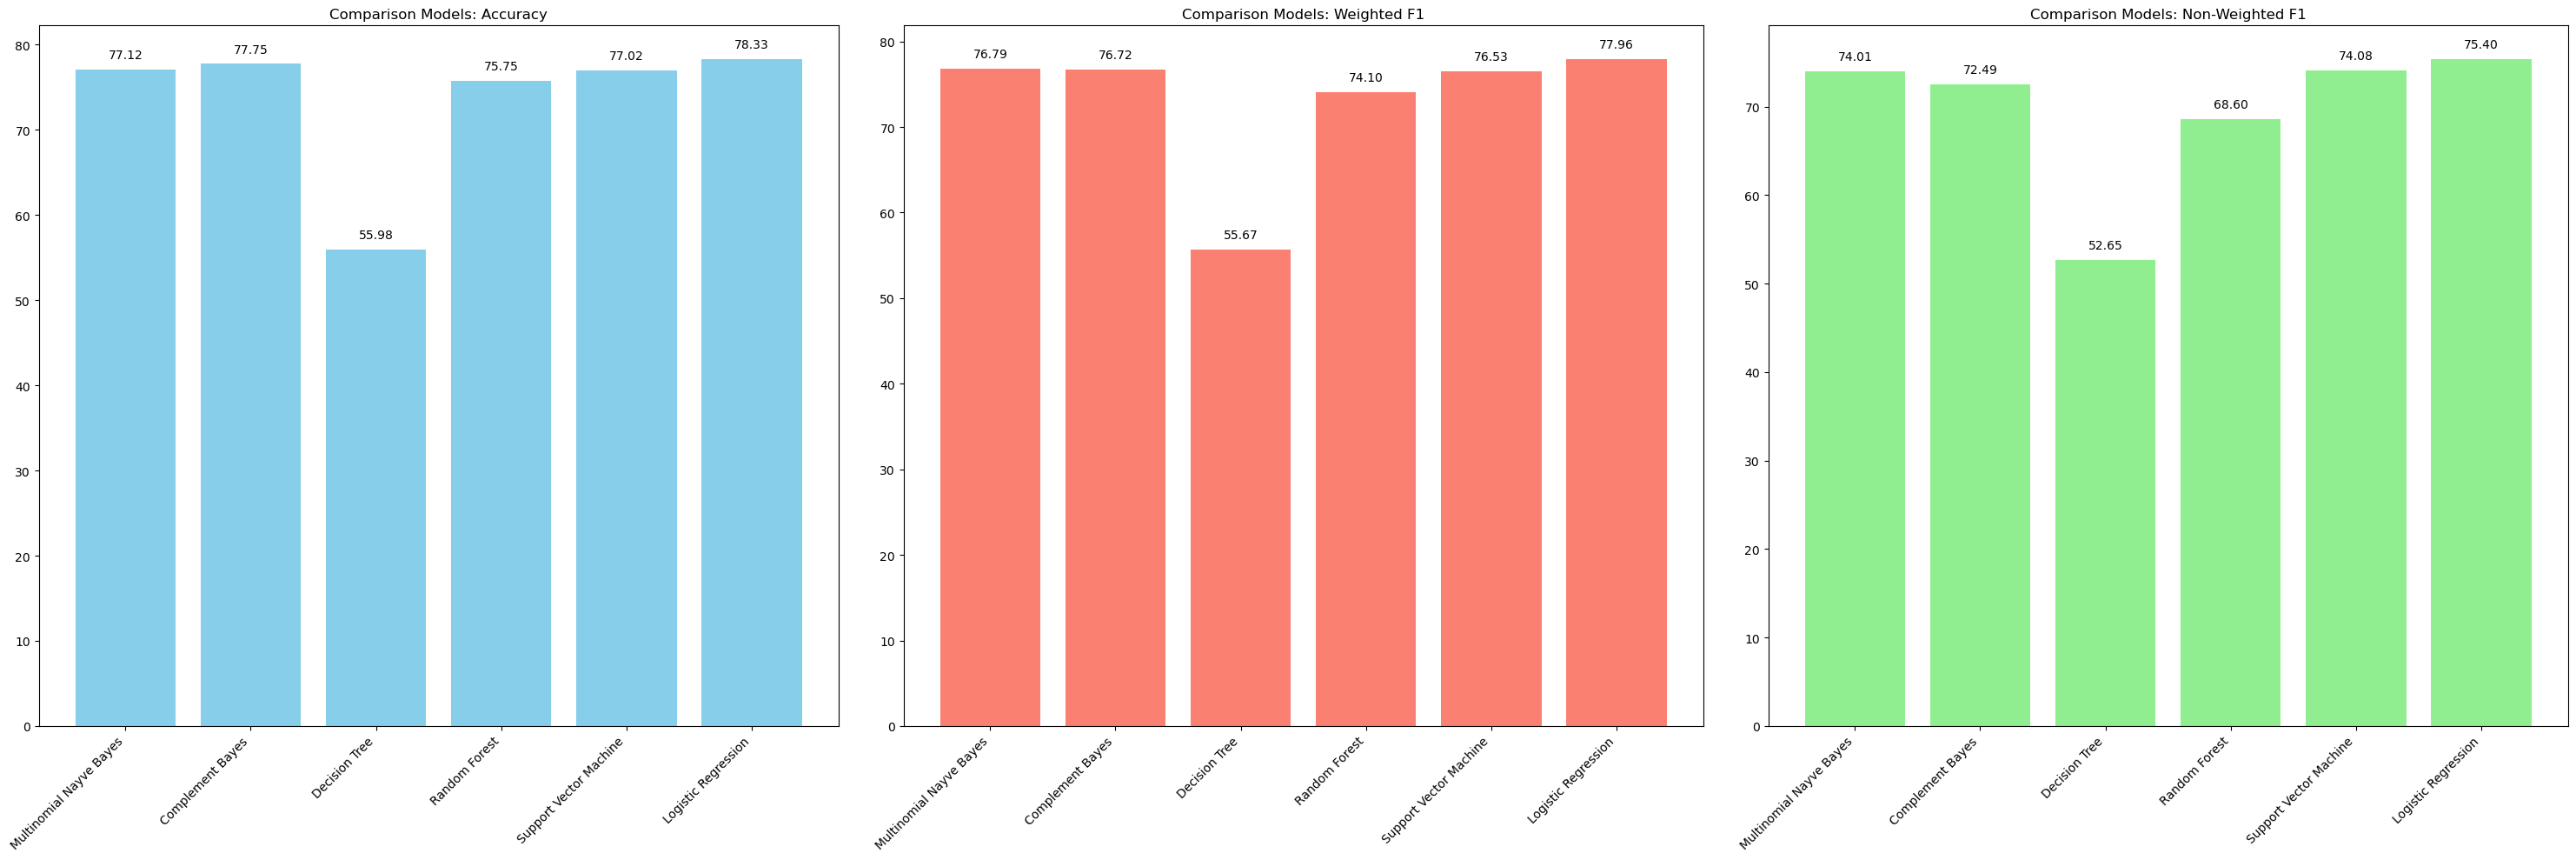

In [82]:
models = ['Multinomial Nayve Bayes', 'Complement Bayes', 'Decision Tree', 'Random Forest', 'Support Vector Machine', 'Logistic Regression']
values_subplot_Acuurracy = [weighted_mean_MNB*100, weighted_mean*100, (np.mean(BOW_DT_accuracy_results_gini))*100,
                            (np.mean(RF_accuracy_results_gini))*100, (np.mean(accuracy_SVM_mean))*100, (np.mean(accuracy_LR_mean))*100]
values_subplot_F1W = [mean_f1_all_MNB*100, mean_f1_all_1*100, (np.mean(BOW_DT_f1_results_gini))*100,
                      (np.mean(RF_f1_results_gini))*100, (np.mean(f1W_SVM_mean))*100, (np.mean(f1_LR_W_mean))*100]
values_subplot_F1NW = [mean_f1_all_NW*100, mean_f1_all*100, (np.mean(BOW_DT_f1_Nweighted_gini))*100,
                       (np.mean(RF_f1_Nweighted_gini))*100, (np.mean(f1NW_SVM_mean))*100, (np.mean(f1_LR_NW_mean))*100]

fig, axes = plt.subplots(1, 3, figsize=(30, 10))

#Accuracy
bars_accuracy = axes[0].bar(models, values_subplot_Acuurracy, color='skyblue')
axes[0].set_title('Comparison Models: Accuracy')
axes[0].set_xticklabels(models, rotation=45, ha='right')

for bar, value in zip(bars_accuracy, values_subplot_Acuurracy):
    axes[0].text(bar.get_x()+bar.get_width() / 2, value+1,f'{value:.2f}',ha='center',va='bottom')

#F1 weighted
bars_f1w = axes[1].bar(models, values_subplot_F1W, color='salmon')
axes[1].set_title('Comparison Models: Weighted F1')
axes[1].set_xticklabels(models, rotation=45, ha='right')

for bar, value in zip(bars_f1w, values_subplot_F1W):
    axes[1].text(bar.get_x()+bar.get_width() / 2,value + 1,f'{value:.2f}',ha='center',va='bottom')

#F1 non weighted
bars_f1nw = axes[2].bar(models, values_subplot_F1NW, color='lightgreen')
axes[2].set_title('Comparison Models: Non-Weighted F1')
axes[2].set_xticklabels(models, rotation=45, ha='right')

for bar, value in zip(bars_f1nw, values_subplot_F1NW):
    axes[2].text(bar.get_x()+bar.get_width() / 2, value+ 1, f'{value:.2f}',ha='center', va='bottom')

plt.tight_layout()

plt.show()


# The Champion: 

![Image Alt Text](https://miro.medium.com/v2/resize:fit:720/format:webp/1*afStrSMwL8jUvQGkok9R2g.jpeg)


